### True eclipse minimum vs Fitted eclipse minimum
1. Sampling from a Gaussian function with 0.25 magnitude eclipse depth, and 300 sec half-width.
2. generate sample light curve
3. Fit with a Gaussian profile to determine the time of minimum
4. repeated 1000 times with different times of minima varying from -100 sec to +100 sec 
5. record the difference between the true time of minimum and the fitted time of minimum

6. repeat this process for each true time of minimum epoch


In [431]:
# imports of external packages to use in our code
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
from scipy.stats import norm
from  scipy.optimize import curve_fit as fit

# define constant
sec = 1
day = 86400* sec
year = 365* day

# default number of images per light curve (data point)
N_images = 100  

# default number of light curves simulated
Nexp = 1000

# default print option
print_option = True

# Specify eclipse params
stdev = 0.025; 
depth = 0.7; 
fwhm = 300

# Specify exposure time, gap between exposures, number of images, sample time
t_exp = 60; t_gap = 10; t_sample = 0.01

# change of exposure time
t_exp2 = 10

# define gaussian function 
def f_gauss(t, depth, fwhm, t_ctr):
    return depth* np.exp( - ((t-t_ctr)/fwhm)**2)

#### True time of eclipse minimum offset w.r.t t=0 extracted from Bogensberger et al 2017 table 1

In [432]:
# True time of eclipse minimum offset w.r.t t=0 
t_off = [0.000769, 0.000724, 0.000612, 0.000665, 0.000744, 0.000685, 0.000745, 0.000803, 0.000706, 0.000717, 
         0.000677, 0.000738, 0.000860, 0.000717, 0.000876, 0.000765, 0.000712, 0.000927, 0.000751, 0.000832, 
         0.000777, 0.000809, 0.000664, 0.000595, 0.000760,0.000717, 0.000705, 0.000794, 0.000553, 0.000782, 
         0.000829, 0.000725, 0.000854, 0.000847, 0.000748, 0.000610, 0.000822, 0.000771, 0.000796]
# convert to seconds
t_off = np.array(t_off)*86400
print(t_off)

[66.4416 62.5536 52.8768 57.456  64.2816 59.184  64.368  69.3792 60.9984
 61.9488 58.4928 63.7632 74.304  61.9488 75.6864 66.096  61.5168 80.0928
 64.8864 71.8848 67.1328 69.8976 57.3696 51.408  65.664  61.9488 60.912
 68.6016 47.7792 67.5648 71.6256 62.64   73.7856 73.1808 64.6272 52.704
 71.0208 66.6144 68.7744]


#### Run many simulations, get distribution of mid-eclipse times

In [440]:
def simulate_fit(t_exp, N_images, Nexp):
    # for every time of minimum measurement, we simulate light curve and solve for minimum
    sim_tm = []
    sim_sig = []
    difference = []
    Sigma = []
    for true in t_off:
        
        # Number of samples per image
        Nsamp = int(t_exp/t_sample)
        # total time of observation [sec]
        t_obs = N_images *(t_exp + t_gap)

        # Calculate amplitude for each image by taking mean of all samples within the exposure time window
        t_image = np.linspace(-t_obs/2,t_obs/2,N_images+1,dtype=int)  # Start time of each image
        t_mid = t_image + t_exp/2.  # Midpoint time of each image
        tt = np.array([np.linspace(t, t+t_exp, Nsamp) for t in t_image])
        S0 = np.mean(f_gauss(tt, depth, fwhm, true),axis=1)

        # Add noise
        sigma = np.random.normal(loc=0,scale=stdev, size=len(S0))
        S = S0 + sigma  
    
        # Uncertainty adjusted for SNR
        yerr = stdev  * 2.5**S0
        
        
####### fit light curve, solve for time of minimum
        parms,cov = fit(f_gauss,t_mid,S,p0=(-1,100,1))
        perr = np.sqrt(np.diag(cov))
        S_fit = f_gauss(t_mid,*parms)
        sim_tm.append(parms[2])
        sim_sig.append(perr[2])
        difference.append(np.abs(parms[2]-true))
        
        if print_option == True:
            print ('Fitted eclipse minimum time')
            print ('Actual = %.1f sec' % true)
            print ('Fitted = %.1f +/- %.1f sec' % (parms[2], perr[2]))
            print ('Difference = %.1f sec' % (np.abs(parms[2]-true)))
            
        plt.figure(figsize=(8,5))
        plt.errorbar(t_mid,-S,yerr= yerr,fmt='o')
        plt.plot(t_mid,-S_fit,'r-')
        plt.xlabel('Time of minima [sec]')
        plt.ylabel('Differiential Magnitude ')
        plt.grid()
        plt.show()
        
####### Repeat 1000 times, get eclipse timing distribution for each measurement 
        diff = []
        nbins =30
        for j in range(Nexp):
            # Add noise each instance in loop
            sigma = np.random.normal(loc=0,scale=stdev, size=len(S))
            S = S0 + sigma
            # Uncertainty
            yerr = stdev  * 2.5**-S0
            parms,cov = fit(f_gauss,t_mid,S,p0=(1,true,0))
            perr = np.sqrt(np.diag(cov))
            S_fit = f_gauss(t_mid,*parms)
            diff.append(parms[2]-true)
        D_mean = np.mean(diff)
        print ('Mean Difference = %.1f sec' % D_mean)
        
 
        plt.clf()
        plt.figure(figsize=(8,5))
        plt.hist(diff,bins=nbins,histtype='step',lw=2,color='red',density=True)
        
####### Fit gaussian to histogram
        bin_count,bin_value = np.histogram(diff,bins=nbins,density=True)
        mid_value = [(bin_value[j]+bin_value[j+1])/2. for j in range(len(bin_value)-1)]
        x = np.array(mid_value)
        y = np.array(bin_count)
        p0 = (np.max(y),5,0)
        parms,cov = fit(f_gauss,x,y,p0=p0, maxfev = 8000)
        y_fit = f_gauss(x,*parms)
        plt.plot(x,y_fit,'k--',label='Gaussian fit')
        plt.grid()
        plt.xlabel('Difference [sec]')
        plt.ylabel('Fractional count')
        plt.xlim(-25,25)
        plt.legend()
        Sigma.append(parms[1]/2)
        print('Sigma = %.1f' % (parms[1]/2) )
        #plotname = 'simulated_histogram.pdf'
        #plt.savefig(plotname)
        plt.show()
        
    return sim_tm, sim_sig, difference, Sigma

Fitted eclipse minimum time
Actual = 66.4 sec
Fitted = 71.3 +/- 3.9 sec
Difference = 4.9 sec


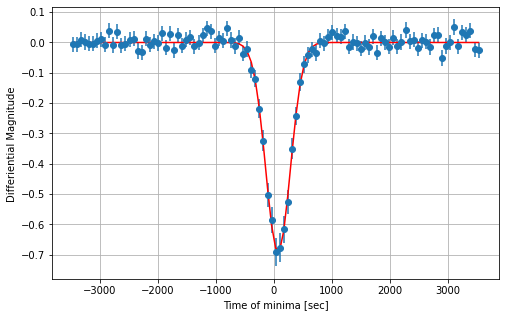

Mean Difference = 0.1 sec
Sigma = 3.2


<Figure size 432x288 with 0 Axes>

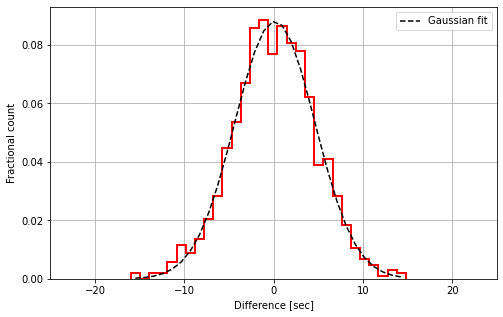

Fitted eclipse minimum time
Actual = 62.6 sec
Fitted = 64.0 +/- 4.1 sec
Difference = 1.5 sec


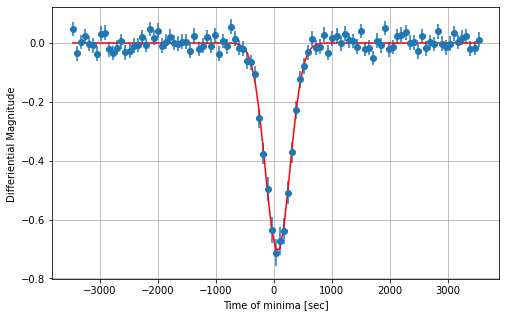

Mean Difference = 0.1 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

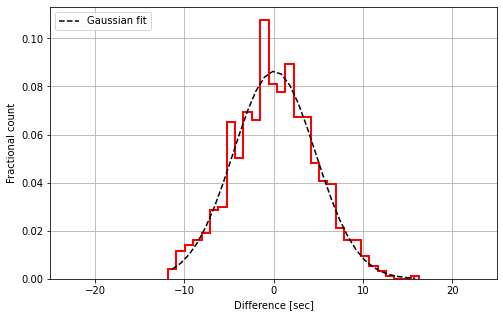

Fitted eclipse minimum time
Actual = 52.9 sec
Fitted = 51.5 +/- 5.1 sec
Difference = 1.3 sec


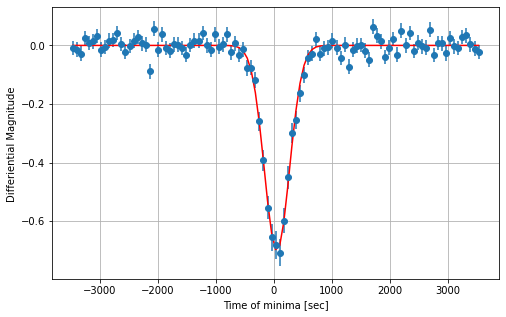

Mean Difference = -0.0 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

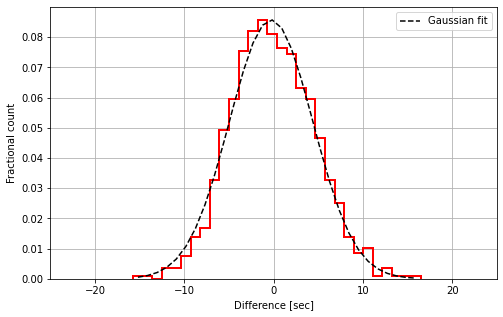

Fitted eclipse minimum time
Actual = 57.5 sec
Fitted = 63.9 +/- 4.7 sec
Difference = 6.4 sec


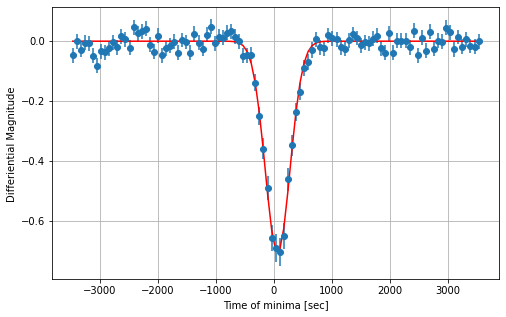

Mean Difference = -0.1 sec
Sigma = 3.5


<Figure size 432x288 with 0 Axes>

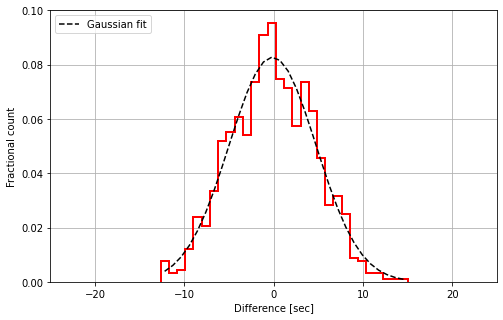

Fitted eclipse minimum time
Actual = 64.3 sec
Fitted = 74.0 +/- 4.3 sec
Difference = 9.8 sec


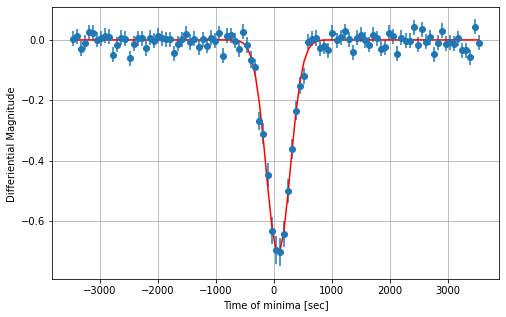

Mean Difference = -0.1 sec
Sigma = 3.5


<Figure size 432x288 with 0 Axes>

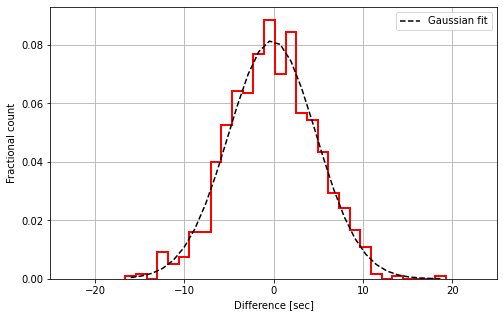

Fitted eclipse minimum time
Actual = 59.2 sec
Fitted = 60.8 +/- 4.4 sec
Difference = 1.6 sec


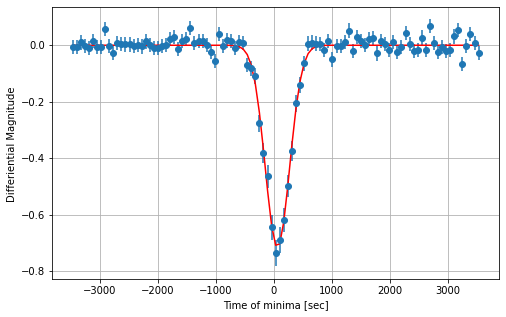

Mean Difference = -0.1 sec
Sigma = 3.1


<Figure size 432x288 with 0 Axes>

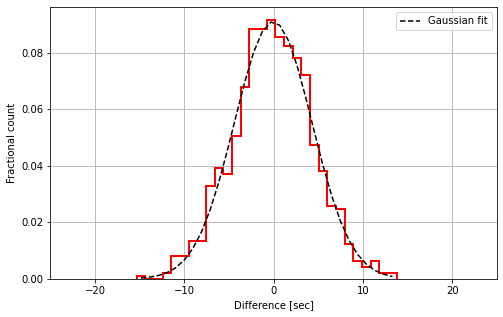

Fitted eclipse minimum time
Actual = 64.4 sec
Fitted = 68.3 +/- 4.5 sec
Difference = 4.0 sec


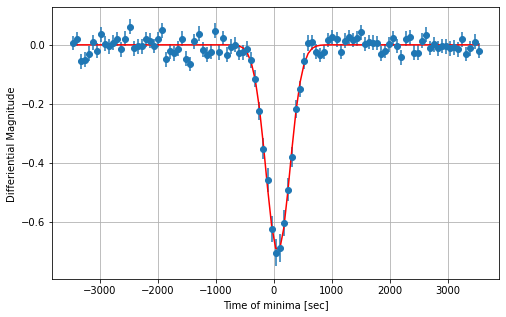

Mean Difference = -0.1 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

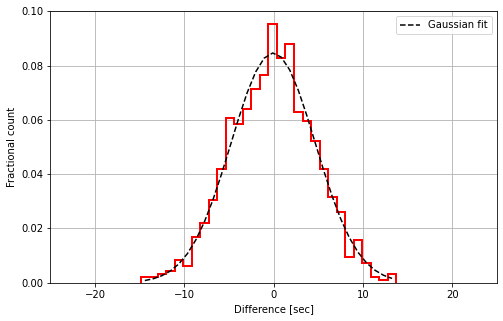

Fitted eclipse minimum time
Actual = 69.4 sec
Fitted = 66.8 +/- 4.7 sec
Difference = 2.5 sec


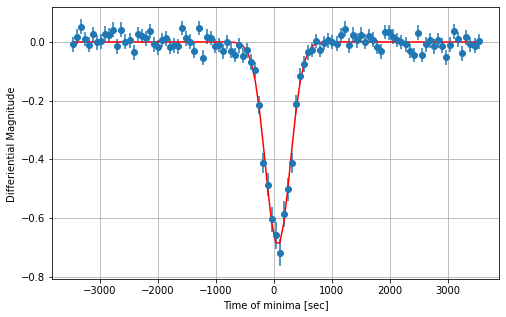

Mean Difference = 0.2 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

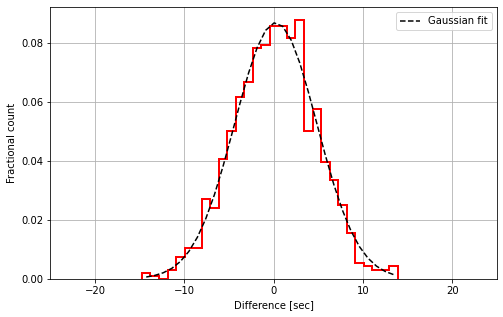

Fitted eclipse minimum time
Actual = 61.0 sec
Fitted = 60.8 +/- 4.6 sec
Difference = 0.2 sec


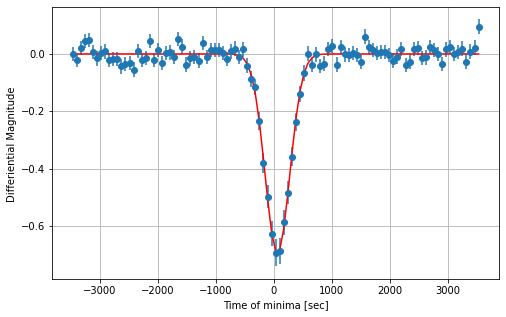

Mean Difference = -0.1 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

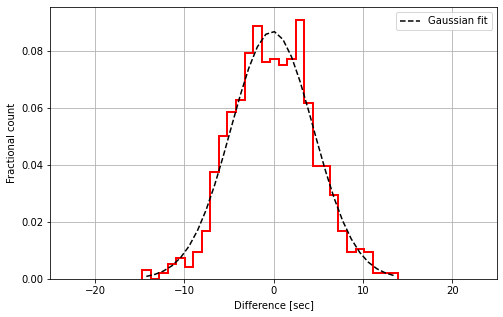

Fitted eclipse minimum time
Actual = 61.9 sec
Fitted = 66.6 +/- 4.4 sec
Difference = 4.7 sec


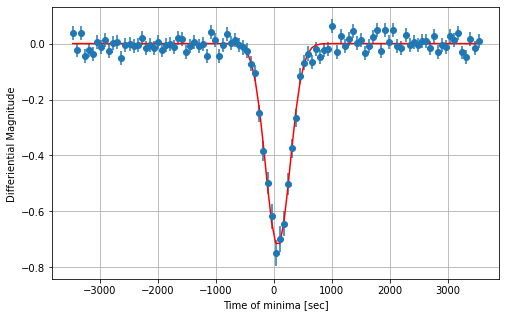

Mean Difference = 0.1 sec
Sigma = 3.2


<Figure size 432x288 with 0 Axes>

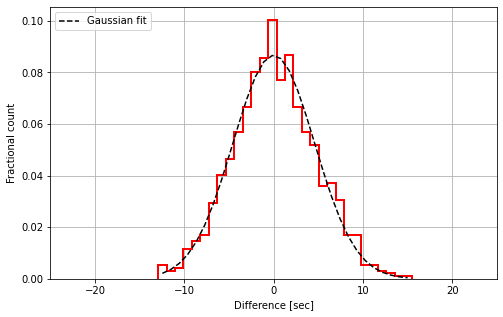

Fitted eclipse minimum time
Actual = 58.5 sec
Fitted = 63.5 +/- 4.3 sec
Difference = 5.0 sec


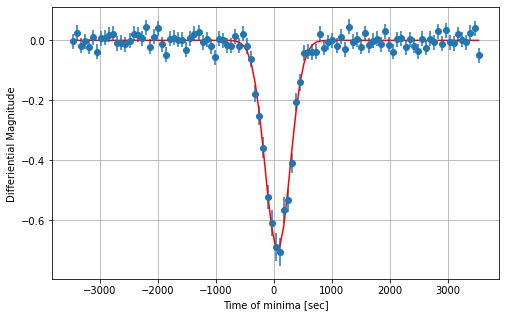

Mean Difference = 0.1 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

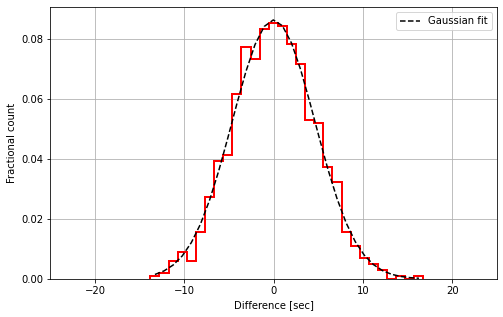

Fitted eclipse minimum time
Actual = 63.8 sec
Fitted = 66.6 +/- 4.3 sec
Difference = 2.9 sec


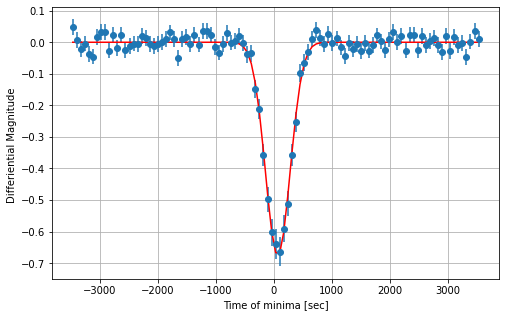

Mean Difference = 0.0 sec
Sigma = 3.1


<Figure size 432x288 with 0 Axes>

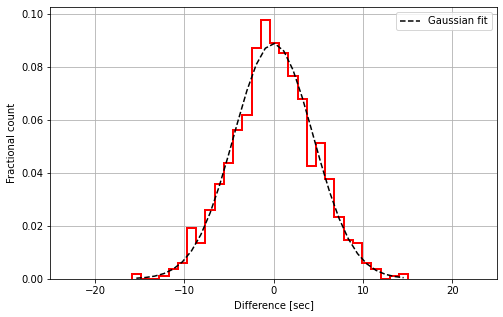

Fitted eclipse minimum time
Actual = 74.3 sec
Fitted = 73.4 +/- 4.8 sec
Difference = 0.9 sec


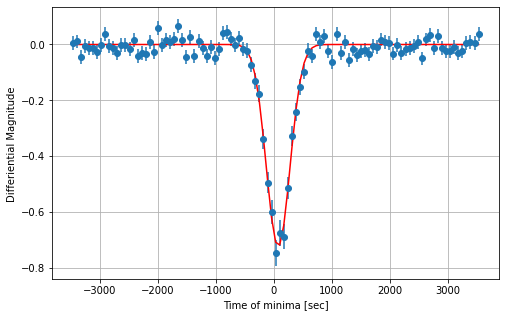

Mean Difference = 0.1 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

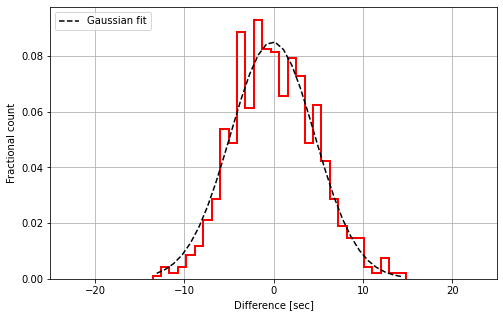

Fitted eclipse minimum time
Actual = 61.9 sec
Fitted = 64.0 +/- 4.5 sec
Difference = 2.1 sec


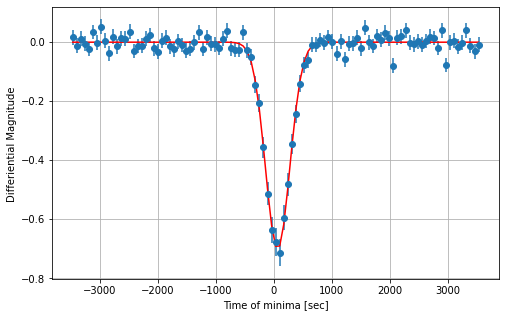

Mean Difference = 0.1 sec
Sigma = 3.4


<Figure size 432x288 with 0 Axes>

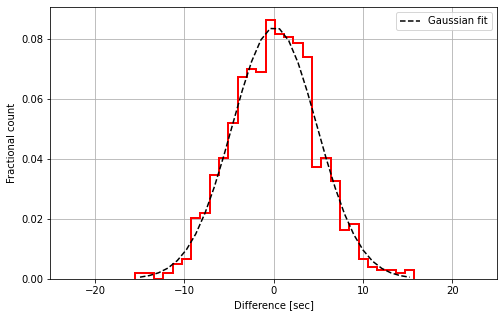

Fitted eclipse minimum time
Actual = 75.7 sec
Fitted = 76.6 +/- 5.0 sec
Difference = 0.9 sec


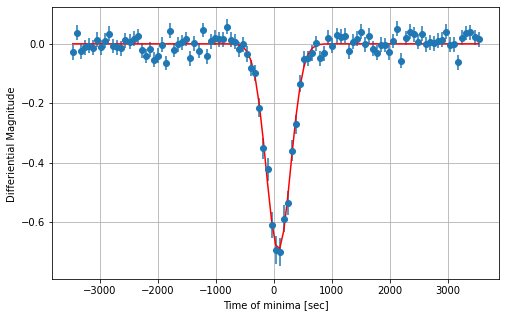

Mean Difference = 0.0 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

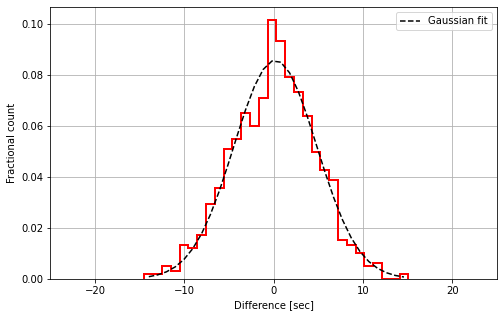

Fitted eclipse minimum time
Actual = 66.1 sec
Fitted = 57.2 +/- 4.9 sec
Difference = 8.9 sec


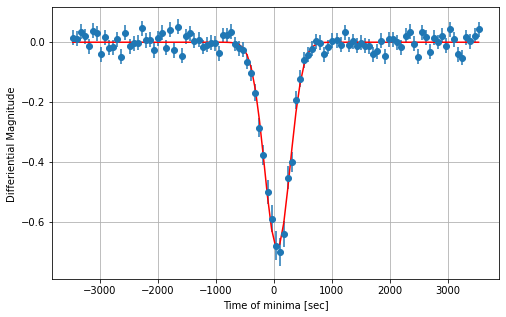

Mean Difference = 0.1 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

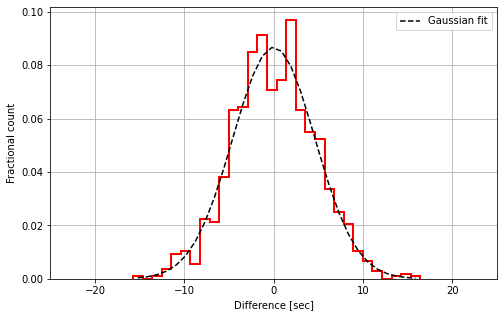

Fitted eclipse minimum time
Actual = 61.5 sec
Fitted = 60.4 +/- 4.8 sec
Difference = 1.1 sec


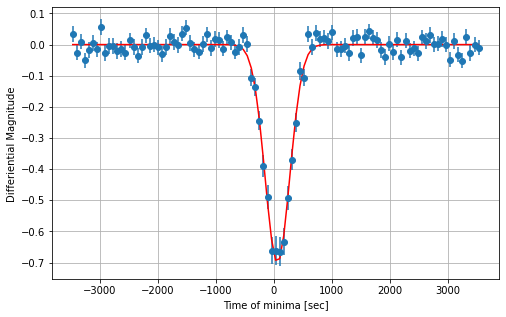

Mean Difference = 0.0 sec
Sigma = 3.5


<Figure size 432x288 with 0 Axes>

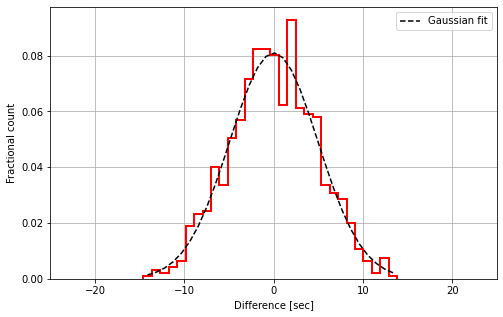

Fitted eclipse minimum time
Actual = 80.1 sec
Fitted = 79.7 +/- 5.3 sec
Difference = 0.4 sec


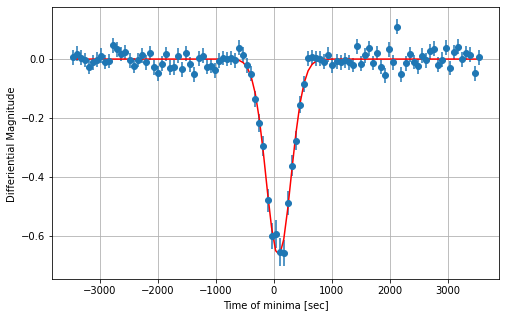

Mean Difference = -0.2 sec
Sigma = 3.4


<Figure size 432x288 with 0 Axes>

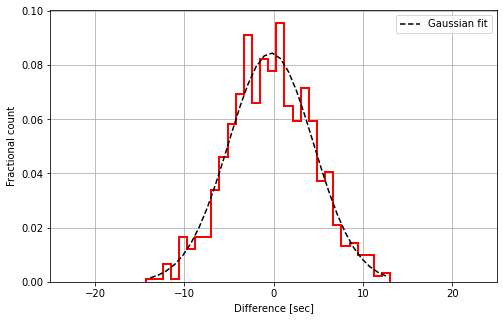

Fitted eclipse minimum time
Actual = 64.9 sec
Fitted = 56.9 +/- 4.7 sec
Difference = 8.0 sec


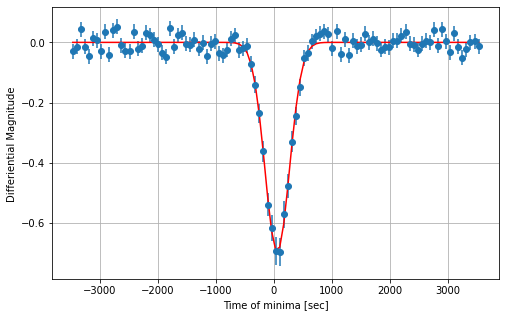

Mean Difference = 0.3 sec
Sigma = 3.6


<Figure size 432x288 with 0 Axes>

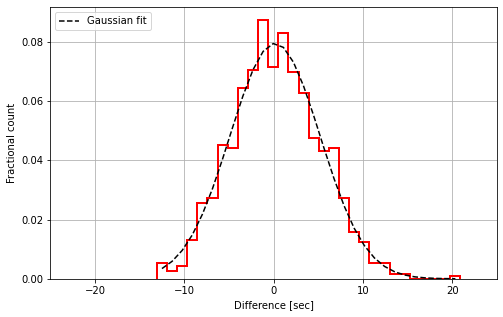

Fitted eclipse minimum time
Actual = 71.9 sec
Fitted = 77.0 +/- 4.5 sec
Difference = 5.1 sec


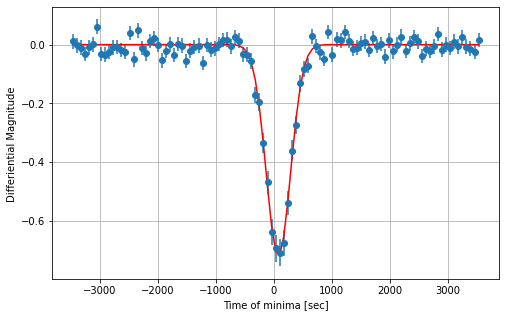

Mean Difference = 0.1 sec
Sigma = 3.2


<Figure size 432x288 with 0 Axes>

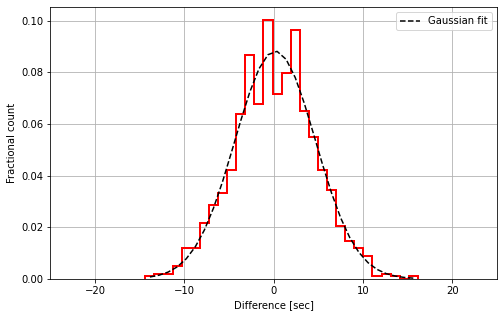

Fitted eclipse minimum time
Actual = 67.1 sec
Fitted = 70.0 +/- 4.6 sec
Difference = 2.9 sec


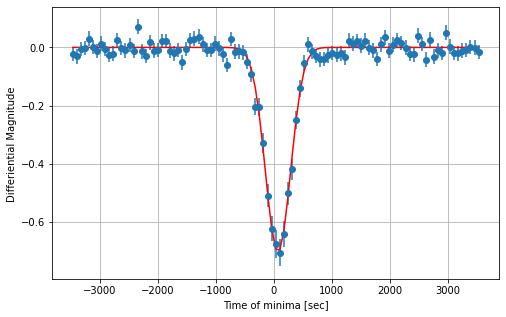

Mean Difference = 0.1 sec
Sigma = 3.2


<Figure size 432x288 with 0 Axes>

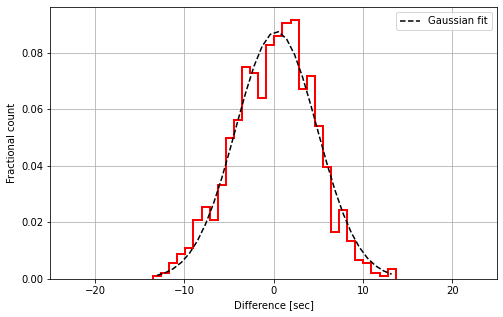

Fitted eclipse minimum time
Actual = 69.9 sec
Fitted = 68.5 +/- 4.6 sec
Difference = 1.4 sec


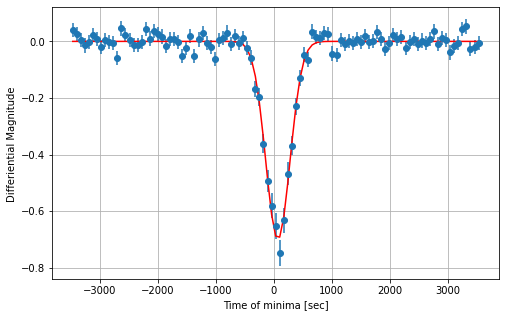

Mean Difference = -0.3 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

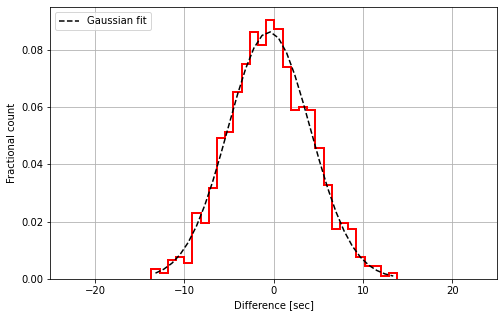

Fitted eclipse minimum time
Actual = 57.4 sec
Fitted = 54.5 +/- 4.7 sec
Difference = 2.9 sec


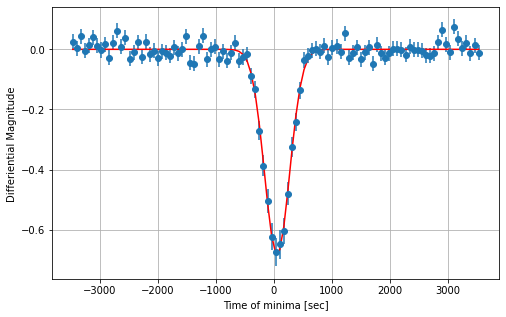

Mean Difference = 0.1 sec
Sigma = 3.2


<Figure size 432x288 with 0 Axes>

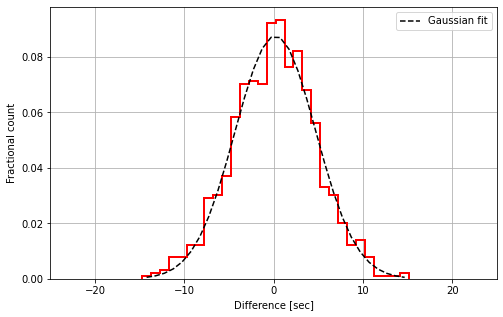

Fitted eclipse minimum time
Actual = 51.4 sec
Fitted = 46.2 +/- 4.9 sec
Difference = 5.2 sec


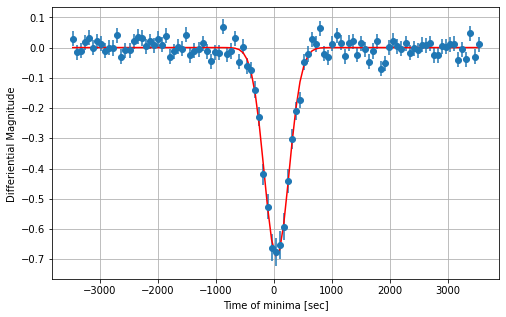

Mean Difference = -0.0 sec
Sigma = 3.2


<Figure size 432x288 with 0 Axes>

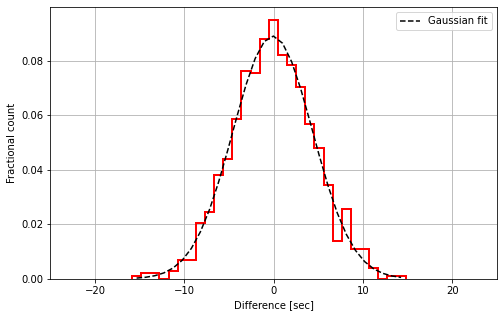

Fitted eclipse minimum time
Actual = 65.7 sec
Fitted = 69.2 +/- 5.0 sec
Difference = 3.5 sec


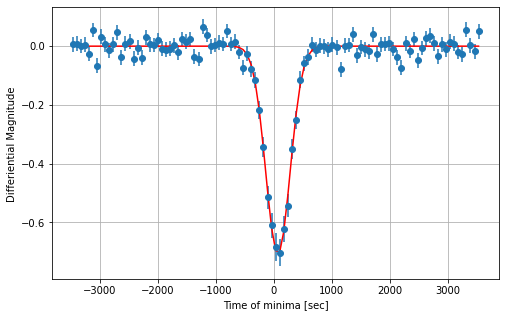

Mean Difference = -0.1 sec
Sigma = 3.2


<Figure size 432x288 with 0 Axes>

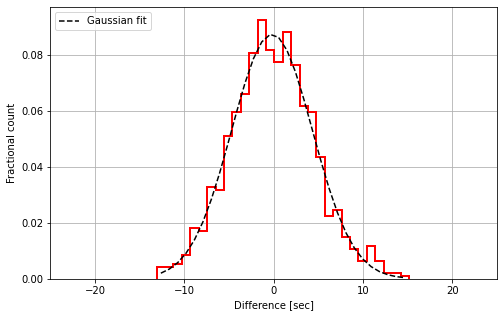

Fitted eclipse minimum time
Actual = 61.9 sec
Fitted = 61.0 +/- 4.5 sec
Difference = 1.0 sec


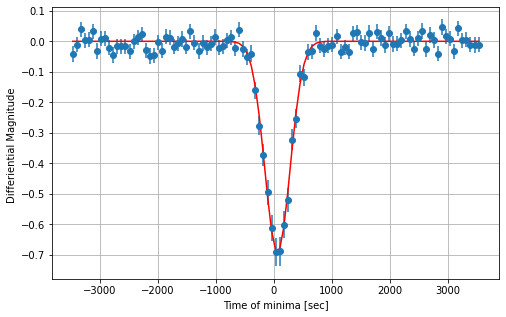

Mean Difference = 0.1 sec
Sigma = 3.5


<Figure size 432x288 with 0 Axes>

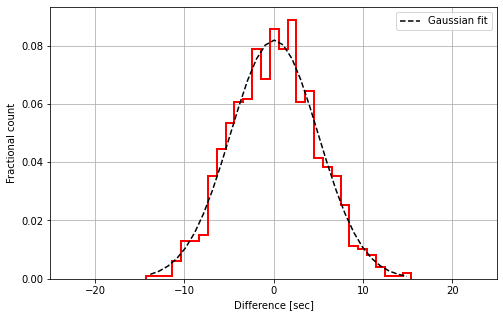

Fitted eclipse minimum time
Actual = 60.9 sec
Fitted = 56.3 +/- 3.9 sec
Difference = 4.6 sec


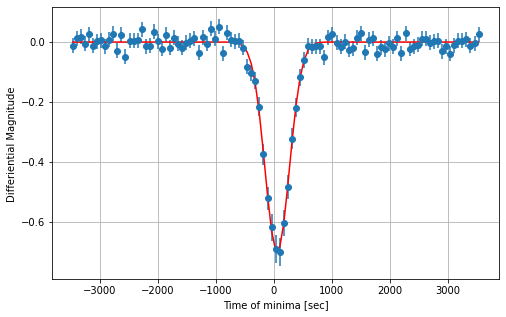

Mean Difference = -0.0 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

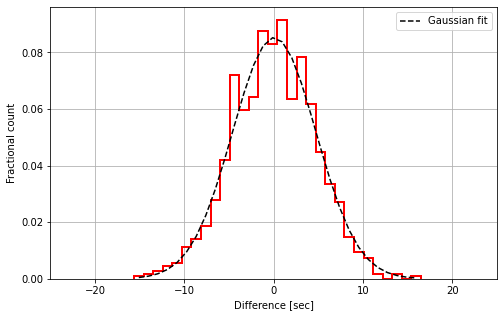

Fitted eclipse minimum time
Actual = 68.6 sec
Fitted = 72.7 +/- 4.6 sec
Difference = 4.1 sec


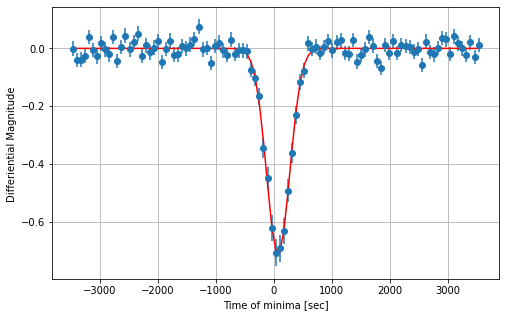

Mean Difference = -0.2 sec
Sigma = 3.4


<Figure size 432x288 with 0 Axes>

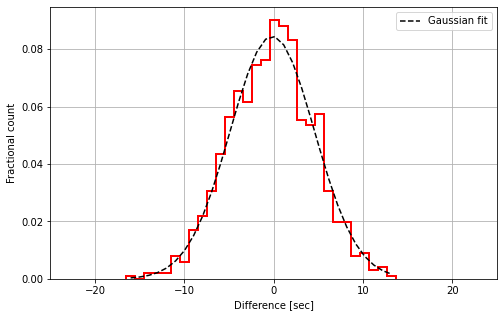

Fitted eclipse minimum time
Actual = 47.8 sec
Fitted = 42.4 +/- 4.2 sec
Difference = 5.4 sec


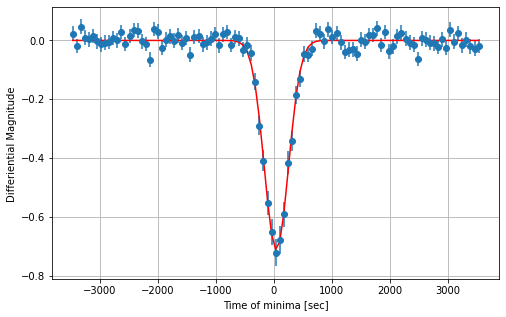

Mean Difference = -0.2 sec
Sigma = 3.1


<Figure size 432x288 with 0 Axes>

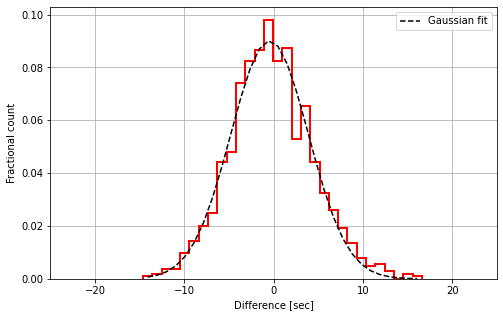

Fitted eclipse minimum time
Actual = 67.6 sec
Fitted = 72.3 +/- 4.7 sec
Difference = 4.7 sec


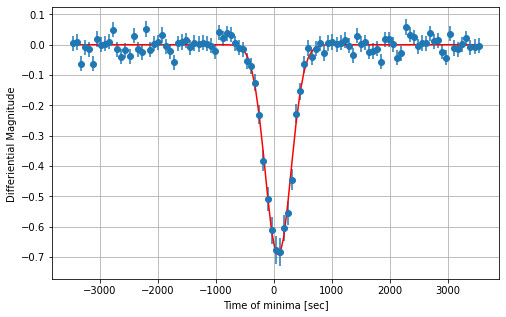

Mean Difference = 0.2 sec
Sigma = 3.4


<Figure size 432x288 with 0 Axes>

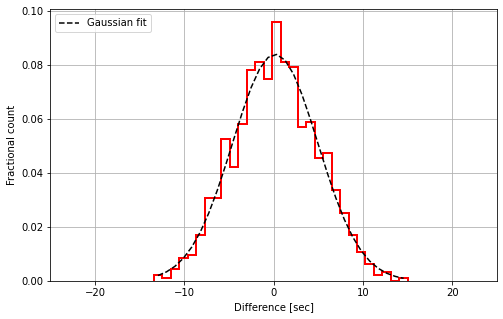

Fitted eclipse minimum time
Actual = 71.6 sec
Fitted = 71.5 +/- 4.9 sec
Difference = 0.1 sec


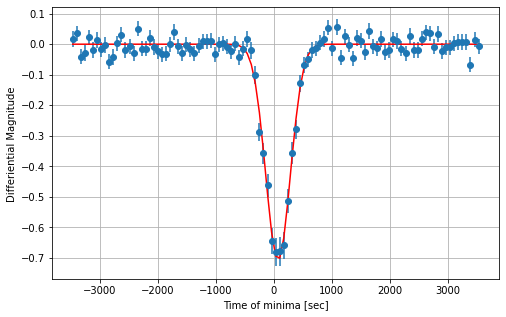

Mean Difference = 0.1 sec
Sigma = 3.0


<Figure size 432x288 with 0 Axes>

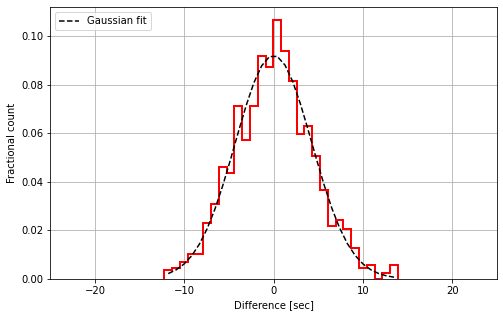

Fitted eclipse minimum time
Actual = 62.6 sec
Fitted = 61.8 +/- 4.9 sec
Difference = 0.9 sec


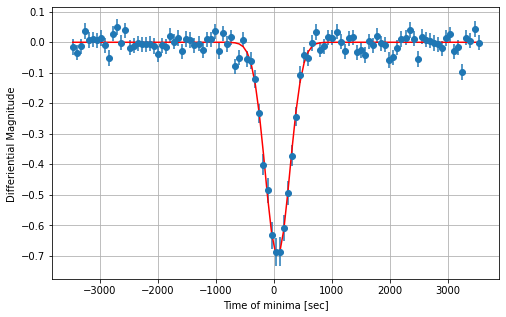

Mean Difference = 0.1 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

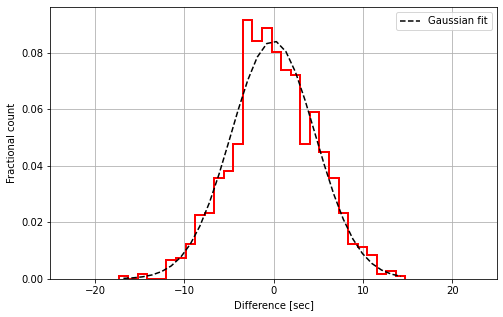

Fitted eclipse minimum time
Actual = 73.8 sec
Fitted = 80.4 +/- 5.1 sec
Difference = 6.6 sec


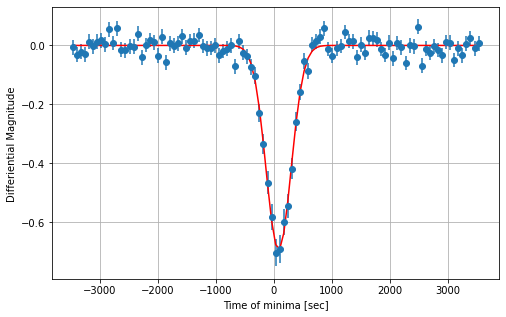

Mean Difference = -0.0 sec
Sigma = 3.4


<Figure size 432x288 with 0 Axes>

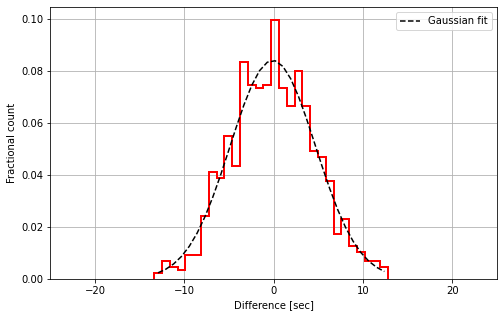

Fitted eclipse minimum time
Actual = 73.2 sec
Fitted = 65.2 +/- 4.5 sec
Difference = 8.0 sec


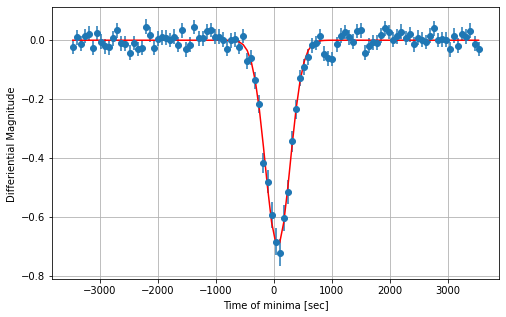

Mean Difference = 0.0 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

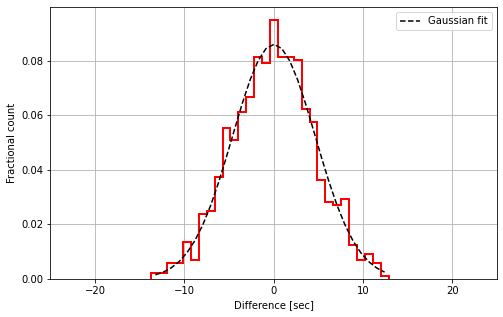

Fitted eclipse minimum time
Actual = 64.6 sec
Fitted = 66.5 +/- 4.5 sec
Difference = 1.9 sec


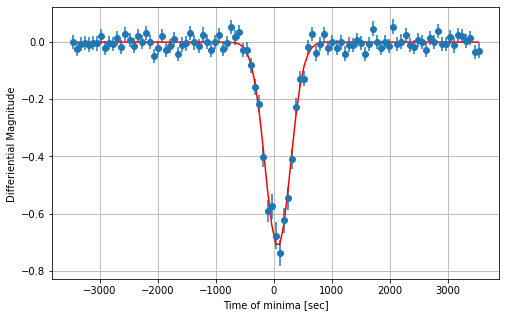

Mean Difference = 0.0 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

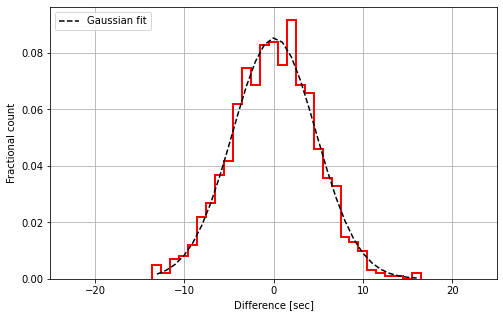

Fitted eclipse minimum time
Actual = 52.7 sec
Fitted = 54.1 +/- 4.5 sec
Difference = 1.4 sec


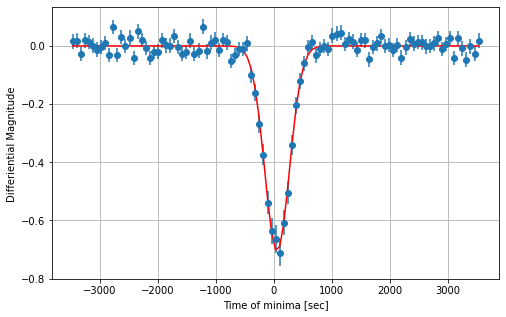

Mean Difference = -0.1 sec
Sigma = 3.2


<Figure size 432x288 with 0 Axes>

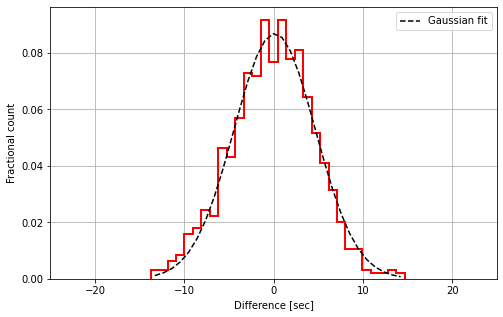

Fitted eclipse minimum time
Actual = 71.0 sec
Fitted = 63.5 +/- 5.0 sec
Difference = 7.5 sec


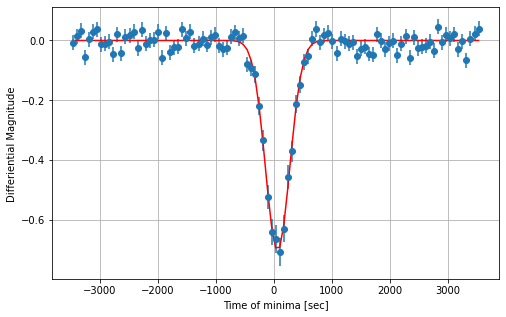

Mean Difference = -0.3 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

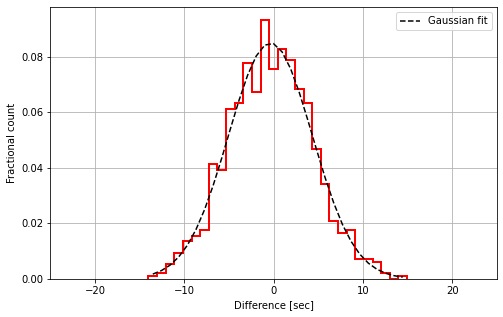

Fitted eclipse minimum time
Actual = 66.6 sec
Fitted = 66.4 +/- 4.7 sec
Difference = 0.2 sec


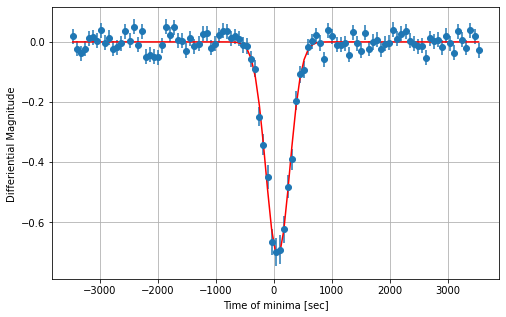

Mean Difference = -0.0 sec
Sigma = 3.3


<Figure size 432x288 with 0 Axes>

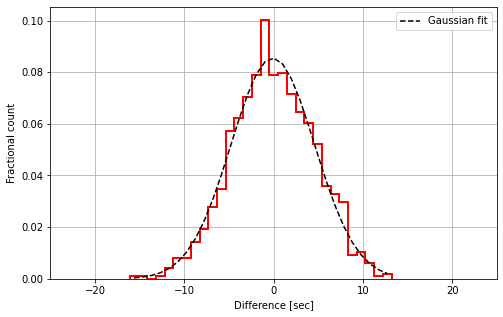

Fitted eclipse minimum time
Actual = 68.8 sec
Fitted = 66.0 +/- 5.1 sec
Difference = 2.8 sec


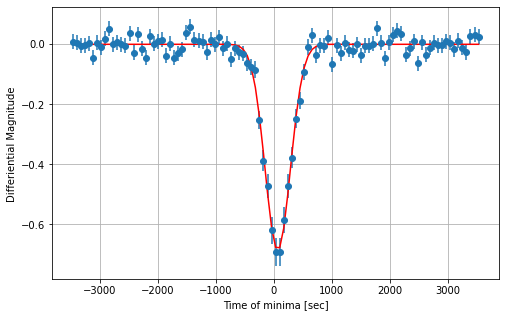

Mean Difference = 0.4 sec
Sigma = 3.2


<Figure size 432x288 with 0 Axes>

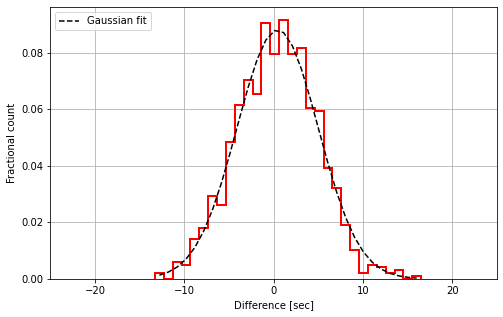

In [441]:
# Using exposure time of 60 sec (as paper did)
output = simulate_fit(t_exp, N_images, Nexp)

## Analysis of true time of minima vs simulated
- The variations in timing can be plotted as “observed minus calculated” diagram over cycle of time 
- This 'O-C' can be interpreted as presence of exoplanets
- We fit fourier component to the O-C curve, explore how many 'sin wave' is needed to fit the data
- we will also fit with our simulated times of minima and compare the difference

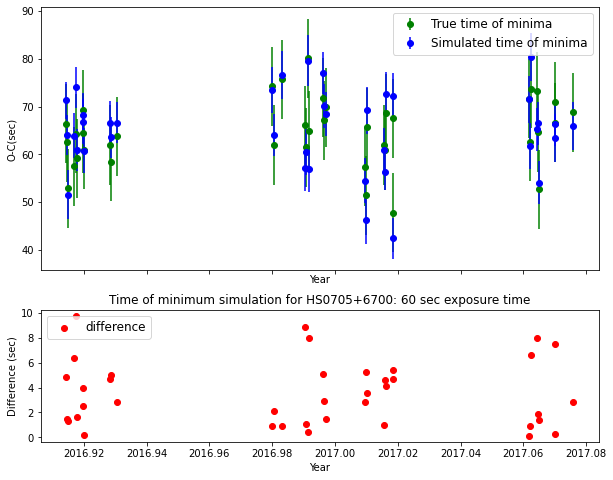

In [445]:
from scipy.stats import chisquare
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from scipy import optimize

# simulate timeline
# HS0705_6700 Parameters
BJD0 = 2450000 *day 
P_binary = 0.095646609 *day # from paper

# Load data: N.B. all times are BJD (extracted from paper)
oc = 'bogensberger_data.txt'
s    = np.loadtxt(oc, unpack=True, dtype=np.str, delimiter=' ',usecols=(2,))
X, Y = np.loadtxt(oc, unpack=True,  delimiter=' ',usecols=(0, 1))

# Convert X,Y to appropriate array names with MKS units
jd_obs = np.array(X) * day
yr_obs = 2018.0  + (jd_obs/day - 2458118.) / 365.25
true_sig  = np.array(Y) * day
  
# Plot Models
f,(p1,p2) = plt.subplots(2,1, sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize= (10,8))
plt.title ('Time of minimum simulation for HS0705+6700: 60 sec exposure time' )
p1.errorbar(yr_obs, t_off, true_sig ,fmt='o',color='g', label = 'True time of minima')
p1.errorbar(yr_obs, output[0], output[1] ,fmt='o',color='b', label = 'Simulated time of minima')
p1.set_xlabel('Year')
p1.set_ylabel('O-C(sec)')
p1.legend(loc='best', fontsize=12) 

p2.scatter(yr_obs, output[2], color='r', label = 'difference')
p2.set_xlabel('Year')
p2.set_ylabel('Difference (sec)')
p2.legend(loc='best', fontsize=12) 
plt.show()

In [443]:
print(output[3])

[3.176122331834843, 3.2615419882342906, 3.3103093281136426, 3.4523373337903167, 3.472066592544722, 3.079556424758193, 3.343381091901008, 3.254231214508469, 3.274255000002976, 3.2374594444727722, 3.2835672463179333, 3.1461496313869826, 3.3412948407031338, 3.3628172030688366, 3.2862780819818416, 3.254924281858073, 3.5050243718702707, 3.358830437302756, 3.5747578386121632, 3.1945631588182315, 3.233705524243904, 3.2754668370753586, 3.19978358976218, 3.1625251800619143, 3.204387461255407, 3.477926228559598, 3.31576133778861, 3.3553053961748334, 3.0796268124490465, 3.386678510165759, 3.041527321478328, 3.3415435773613855, 3.388815440889094, 3.2846582788244127, 3.3122322608209784, 3.232045643538481, 3.3301145028418637, 3.319375961277445, 3.220446124238427]


## Using exposure time of 10 sec (our experiment)

Fitted eclipse minimum time
Actual = 66.4 sec
Fitted = 63.5 +/- 2.4 sec
Difference = 3.0 sec


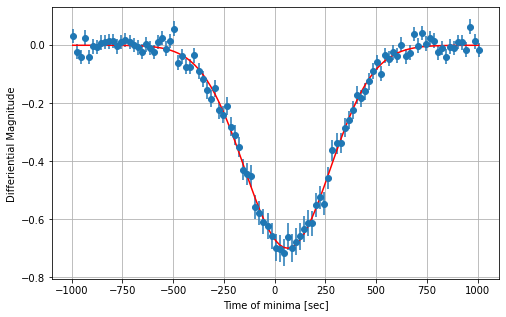

Mean Difference = 0.1 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

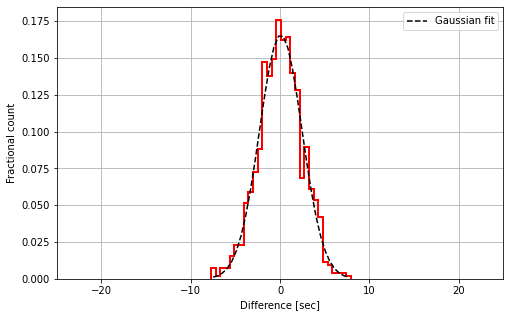

Fitted eclipse minimum time
Actual = 62.6 sec
Fitted = 60.8 +/- 2.4 sec
Difference = 1.7 sec


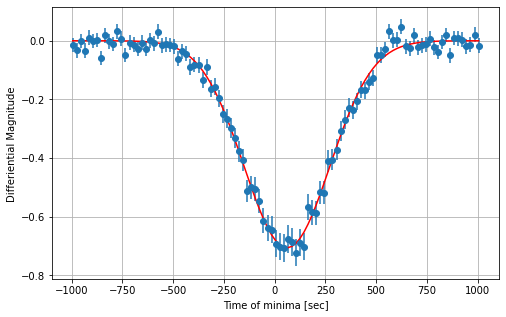

Mean Difference = -0.1 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

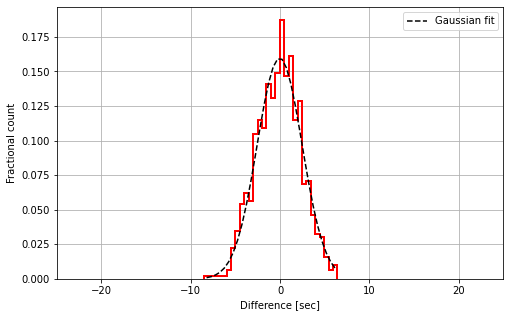

Fitted eclipse minimum time
Actual = 52.9 sec
Fitted = 55.8 +/- 2.7 sec
Difference = 3.0 sec


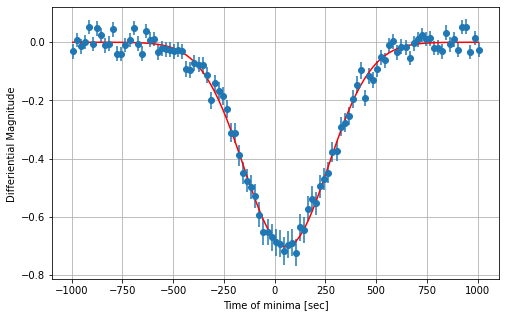

Mean Difference = -0.0 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

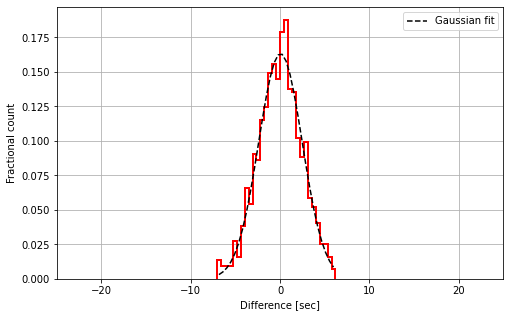

Fitted eclipse minimum time
Actual = 57.5 sec
Fitted = 56.8 +/- 2.7 sec
Difference = 0.6 sec


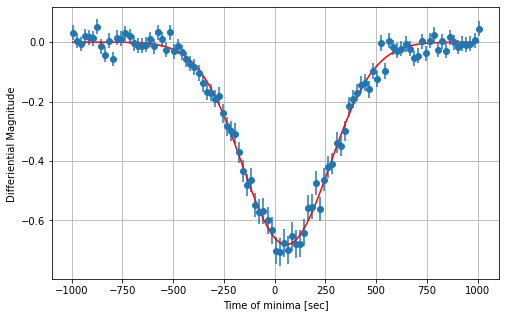

Mean Difference = 0.1 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

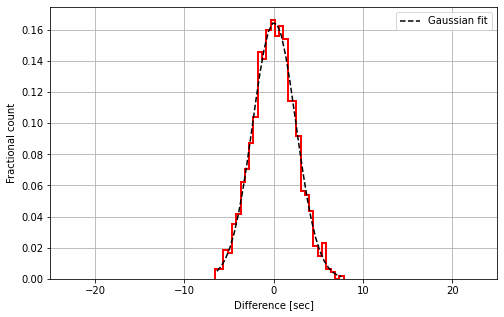

Fitted eclipse minimum time
Actual = 64.3 sec
Fitted = 68.1 +/- 2.4 sec
Difference = 3.8 sec


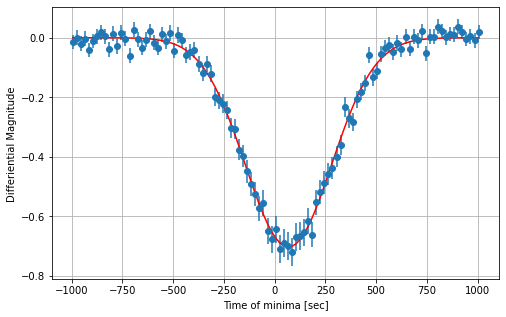

Mean Difference = 0.1 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

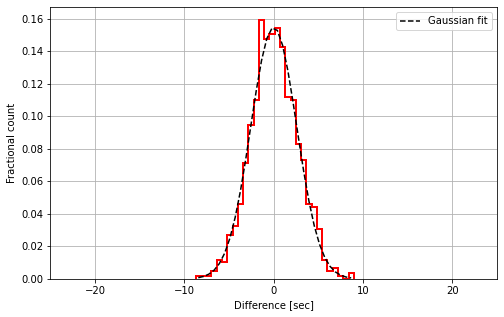

Fitted eclipse minimum time
Actual = 59.2 sec
Fitted = 61.3 +/- 2.4 sec
Difference = 2.1 sec


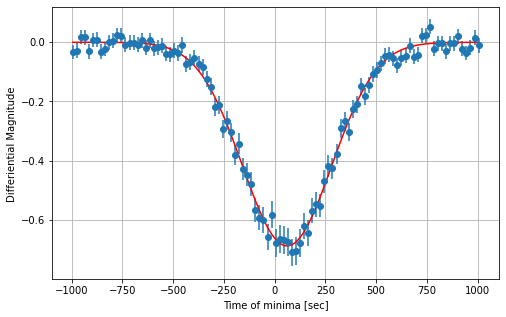

Mean Difference = 0.0 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

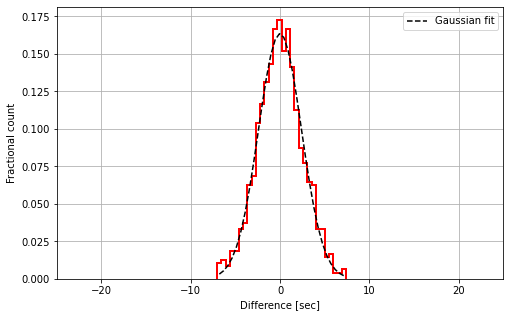

Fitted eclipse minimum time
Actual = 64.4 sec
Fitted = 66.9 +/- 2.5 sec
Difference = 2.5 sec


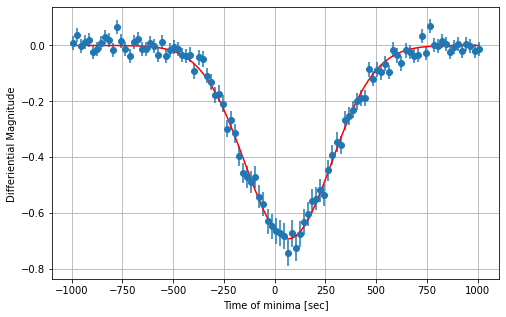

Mean Difference = -0.1 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

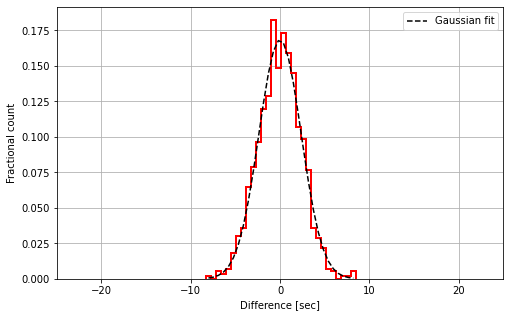

Fitted eclipse minimum time
Actual = 69.4 sec
Fitted = 68.6 +/- 2.4 sec
Difference = 0.8 sec


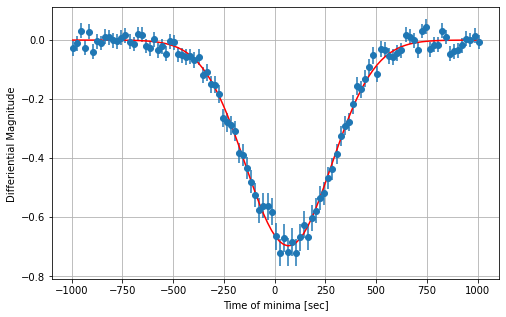

Mean Difference = 0.0 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

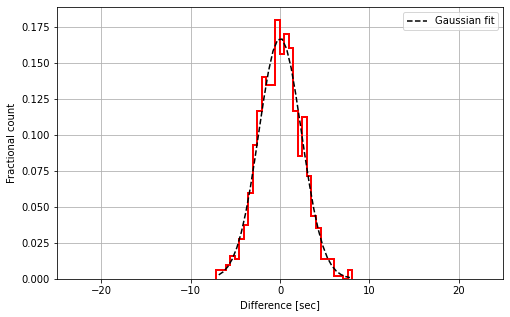

Fitted eclipse minimum time
Actual = 61.0 sec
Fitted = 64.4 +/- 2.7 sec
Difference = 3.4 sec


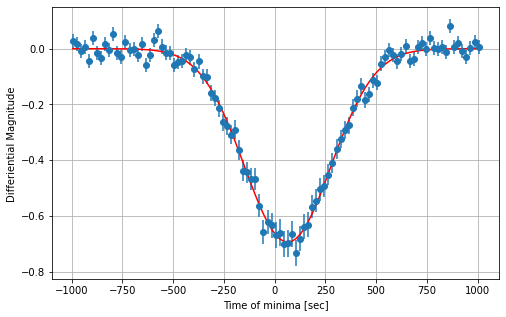

Mean Difference = -0.1 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

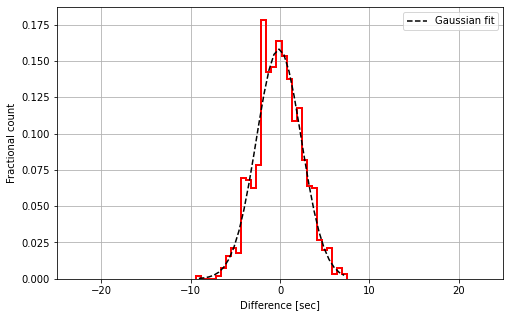

Fitted eclipse minimum time
Actual = 61.9 sec
Fitted = 60.5 +/- 2.5 sec
Difference = 1.4 sec


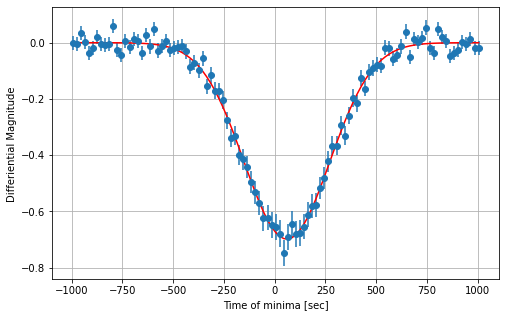

Mean Difference = -0.0 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

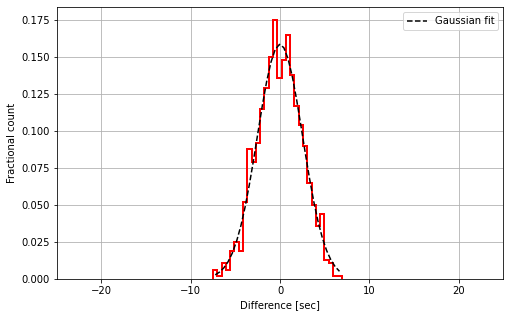

Fitted eclipse minimum time
Actual = 58.5 sec
Fitted = 57.9 +/- 2.5 sec
Difference = 0.6 sec


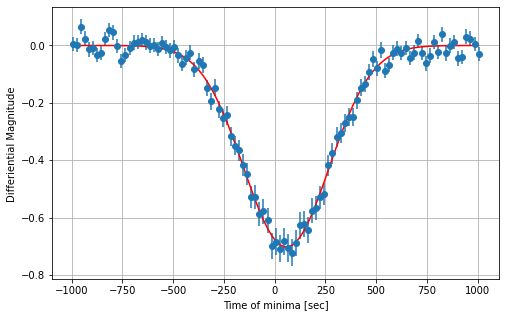

Mean Difference = -0.0 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

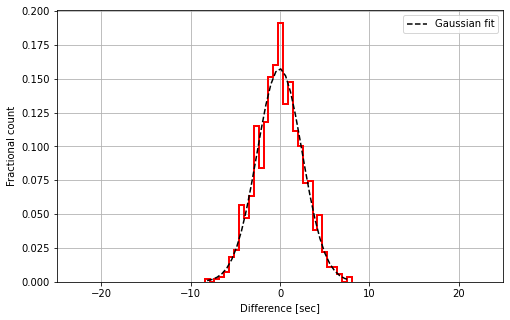

Fitted eclipse minimum time
Actual = 63.8 sec
Fitted = 65.3 +/- 2.3 sec
Difference = 1.5 sec


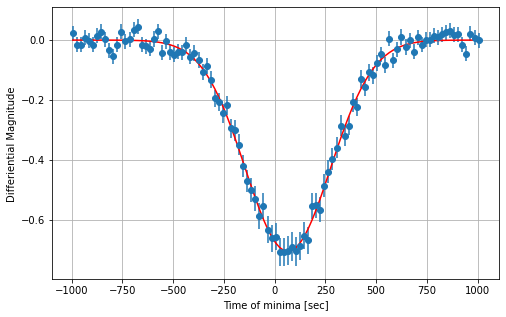

Mean Difference = 0.1 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

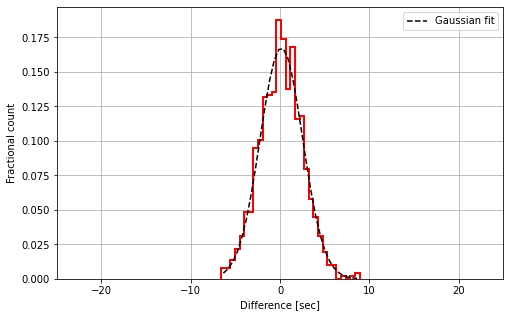

Fitted eclipse minimum time
Actual = 74.3 sec
Fitted = 76.1 +/- 2.2 sec
Difference = 1.8 sec


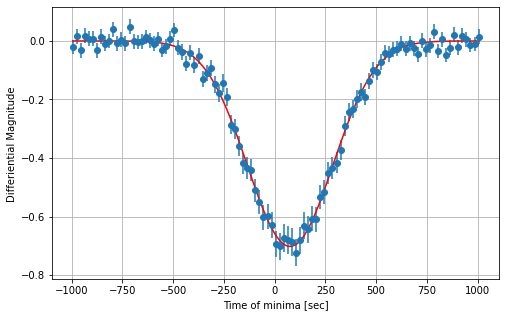

Mean Difference = 0.1 sec
Sigma = 1.9


<Figure size 432x288 with 0 Axes>

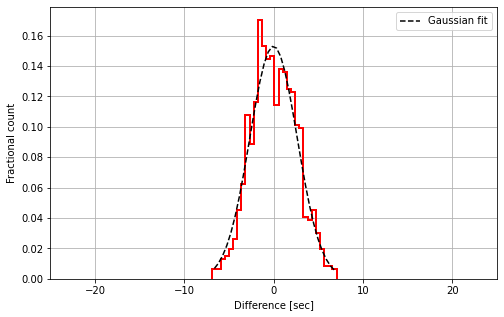

Fitted eclipse minimum time
Actual = 61.9 sec
Fitted = 61.4 +/- 2.7 sec
Difference = 0.6 sec


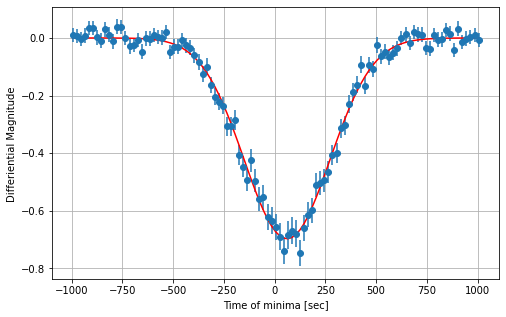

Mean Difference = -0.0 sec
Sigma = 1.9


<Figure size 432x288 with 0 Axes>

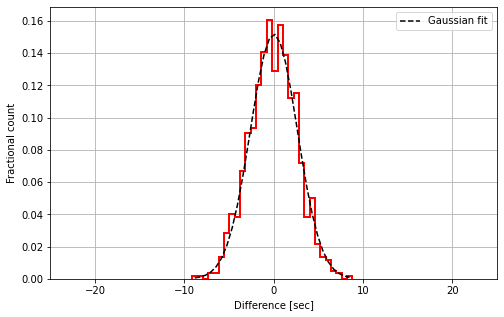

Fitted eclipse minimum time
Actual = 75.7 sec
Fitted = 76.3 +/- 2.6 sec
Difference = 0.6 sec


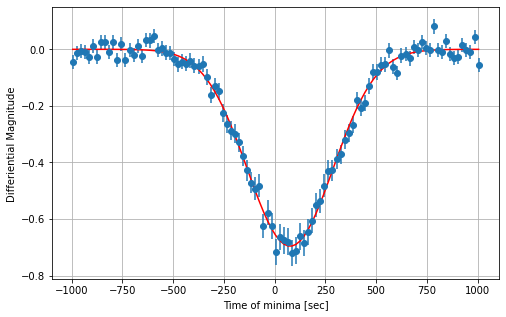

Mean Difference = 0.1 sec
Sigma = 1.9


<Figure size 432x288 with 0 Axes>

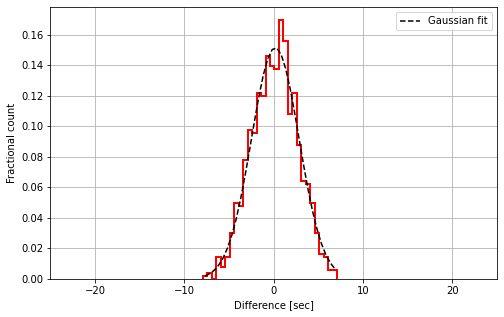

Fitted eclipse minimum time
Actual = 66.1 sec
Fitted = 63.5 +/- 2.4 sec
Difference = 2.6 sec


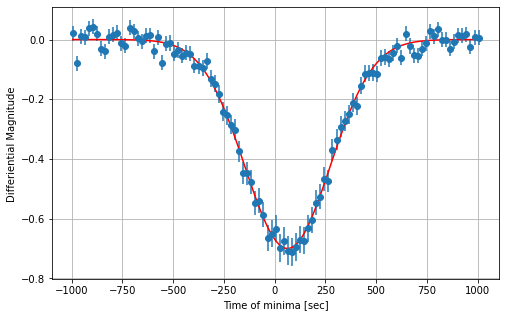

Mean Difference = 0.1 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

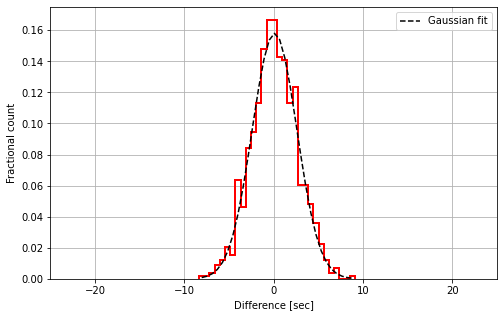

Fitted eclipse minimum time
Actual = 61.5 sec
Fitted = 62.5 +/- 2.6 sec
Difference = 1.0 sec


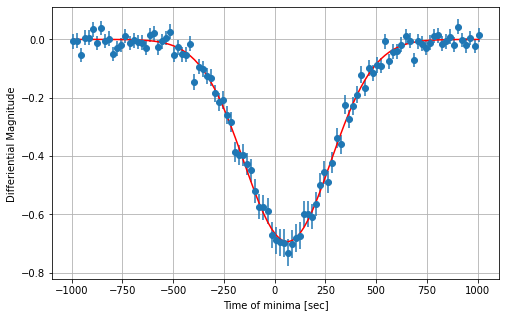

Mean Difference = -0.1 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

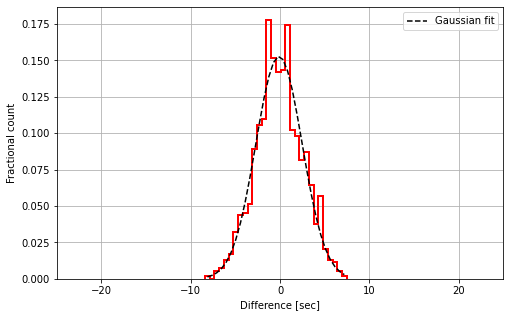

Fitted eclipse minimum time
Actual = 80.1 sec
Fitted = 80.4 +/- 2.1 sec
Difference = 0.3 sec


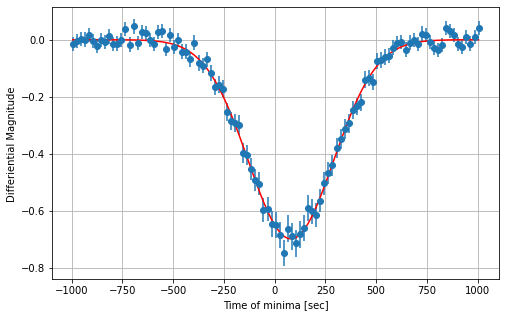

Mean Difference = 0.0 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

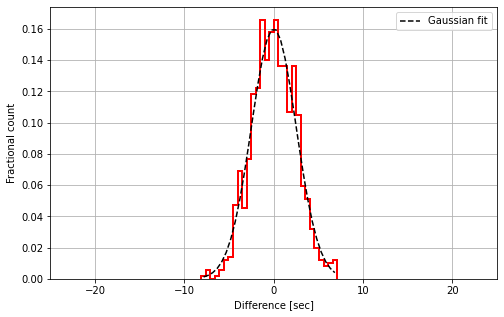

Fitted eclipse minimum time
Actual = 64.9 sec
Fitted = 65.9 +/- 2.7 sec
Difference = 1.0 sec


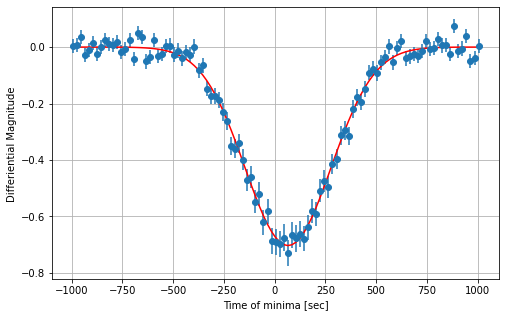

Mean Difference = -0.1 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

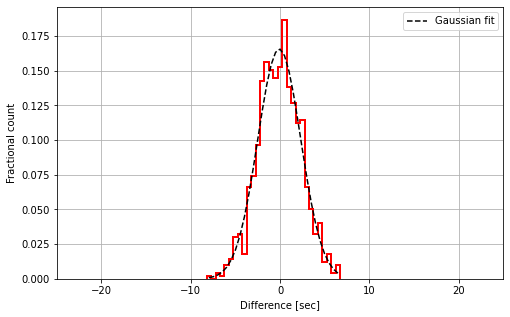

Fitted eclipse minimum time
Actual = 71.9 sec
Fitted = 68.4 +/- 2.8 sec
Difference = 3.5 sec


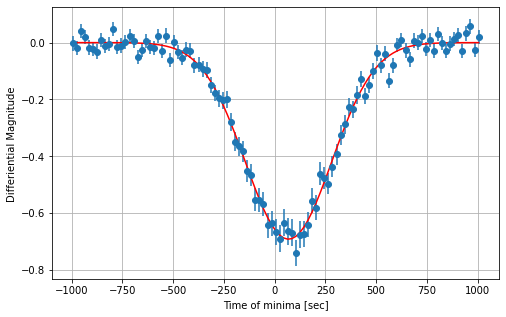

Mean Difference = -0.0 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

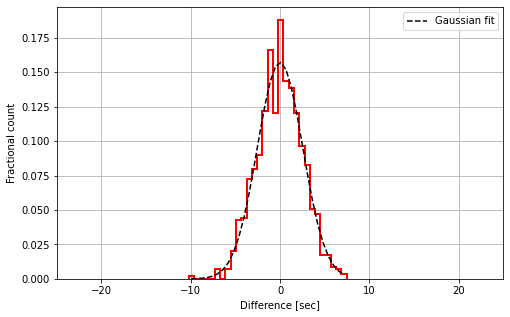

Fitted eclipse minimum time
Actual = 67.1 sec
Fitted = 65.2 +/- 2.5 sec
Difference = 2.0 sec


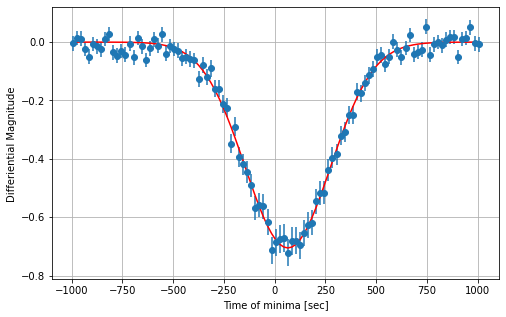

Mean Difference = -0.1 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

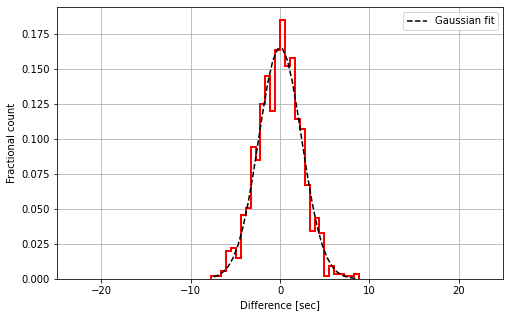

Fitted eclipse minimum time
Actual = 69.9 sec
Fitted = 70.1 +/- 2.3 sec
Difference = 0.2 sec


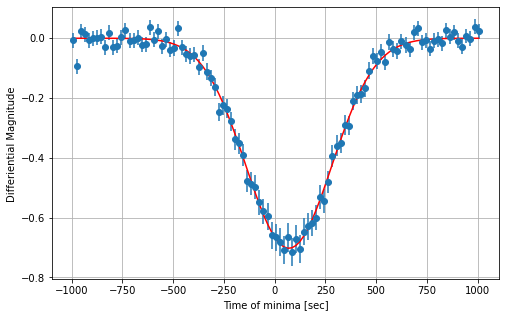

Mean Difference = -0.0 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

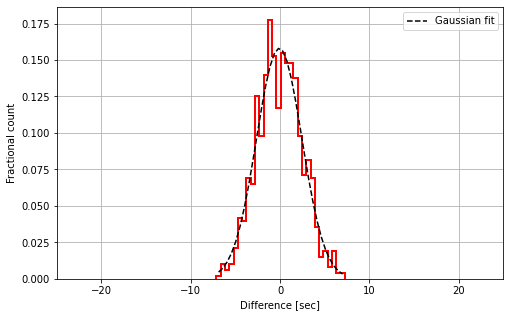

Fitted eclipse minimum time
Actual = 57.4 sec
Fitted = 53.8 +/- 2.4 sec
Difference = 3.6 sec


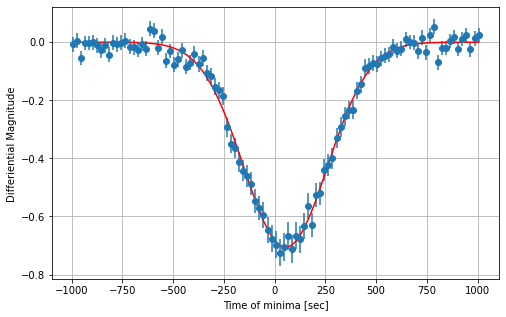

Mean Difference = -0.0 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

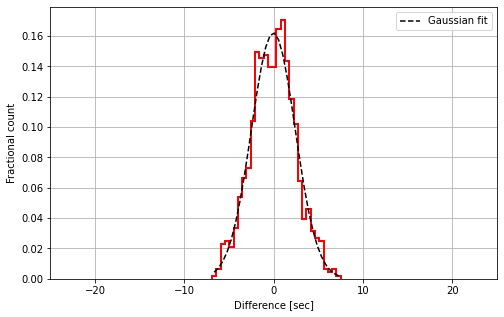

Fitted eclipse minimum time
Actual = 51.4 sec
Fitted = 53.6 +/- 2.5 sec
Difference = 2.2 sec


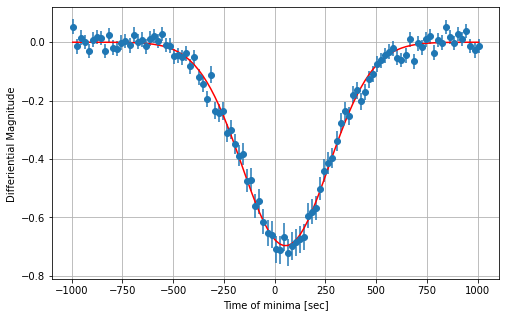

Mean Difference = -0.1 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

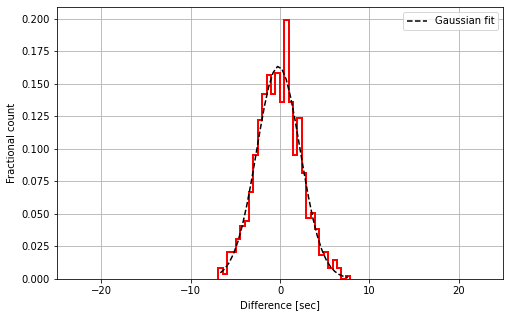

Fitted eclipse minimum time
Actual = 65.7 sec
Fitted = 66.2 +/- 2.6 sec
Difference = 0.6 sec


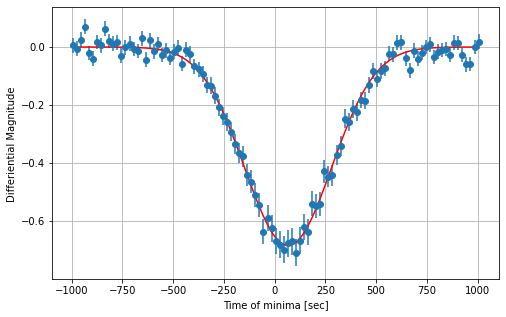

Mean Difference = 0.1 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

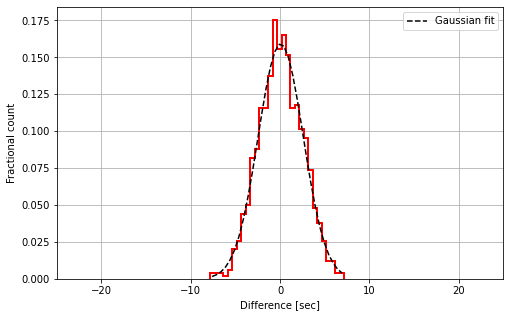

Fitted eclipse minimum time
Actual = 61.9 sec
Fitted = 58.8 +/- 2.2 sec
Difference = 3.2 sec


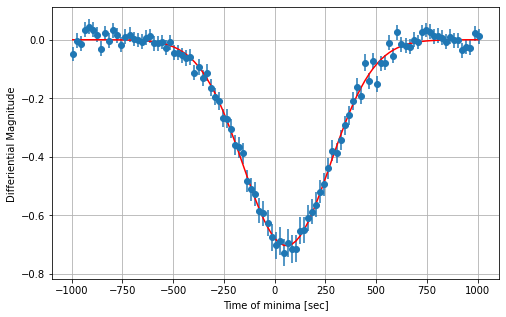

Mean Difference = 0.0 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

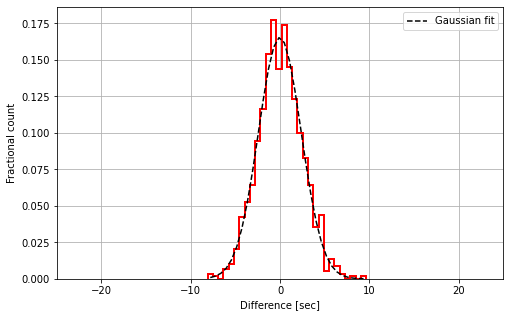

Fitted eclipse minimum time
Actual = 60.9 sec
Fitted = 56.9 +/- 2.8 sec
Difference = 4.0 sec


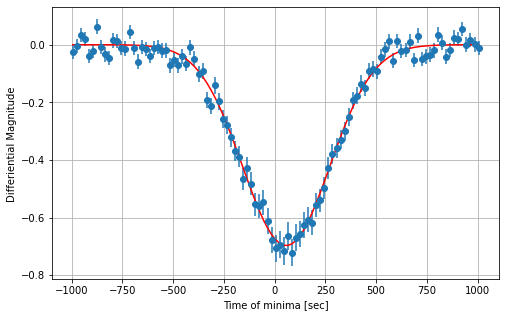

Mean Difference = 0.1 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

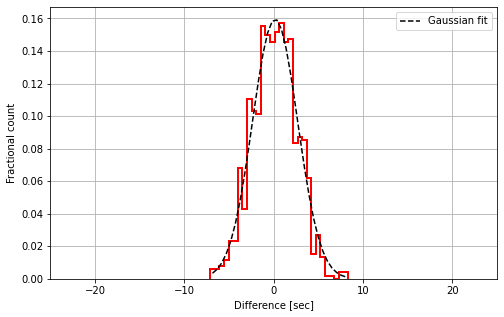

Fitted eclipse minimum time
Actual = 68.6 sec
Fitted = 71.8 +/- 2.7 sec
Difference = 3.2 sec


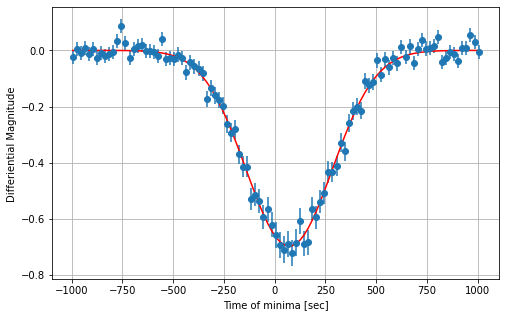

Mean Difference = -0.1 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

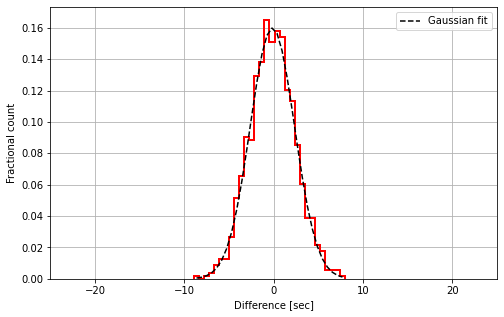

Fitted eclipse minimum time
Actual = 47.8 sec
Fitted = 51.9 +/- 2.5 sec
Difference = 4.1 sec


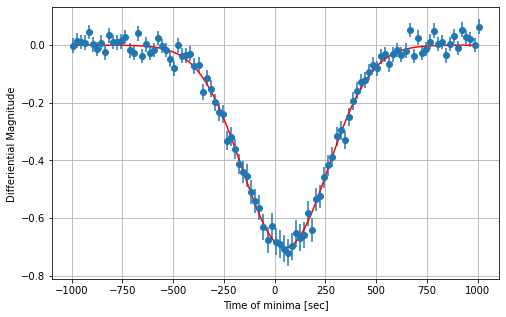

Mean Difference = -0.0 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

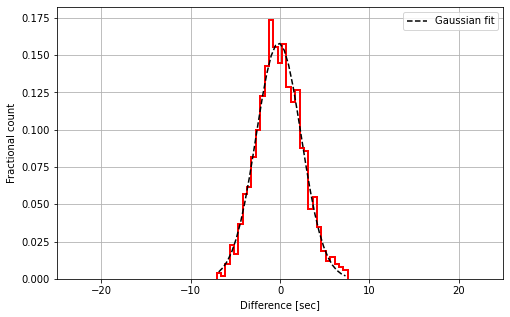

Fitted eclipse minimum time
Actual = 67.6 sec
Fitted = 71.0 +/- 2.2 sec
Difference = 3.4 sec


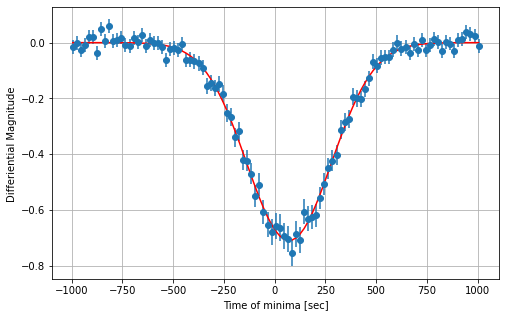

Mean Difference = 0.0 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

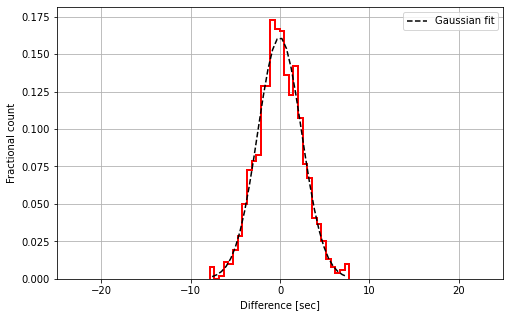

Fitted eclipse minimum time
Actual = 71.6 sec
Fitted = 71.5 +/- 2.3 sec
Difference = 0.1 sec


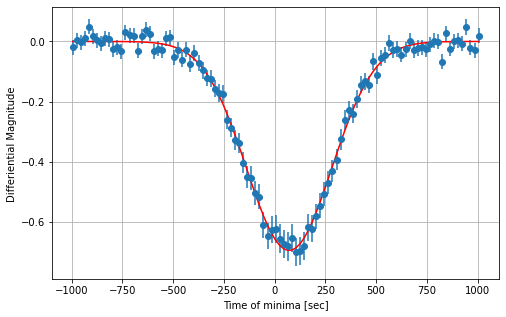

Mean Difference = -0.1 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

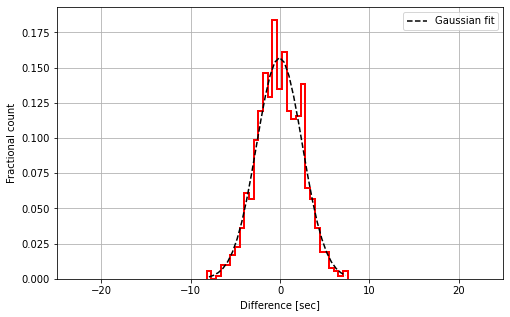

Fitted eclipse minimum time
Actual = 62.6 sec
Fitted = 63.8 +/- 2.5 sec
Difference = 1.2 sec


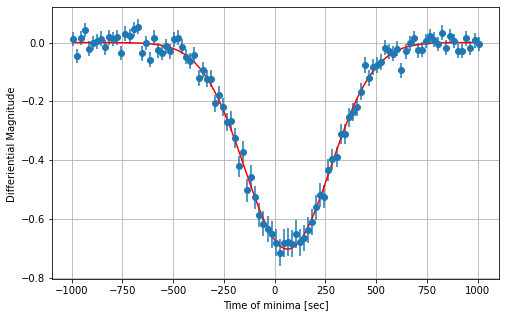

Mean Difference = 0.0 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

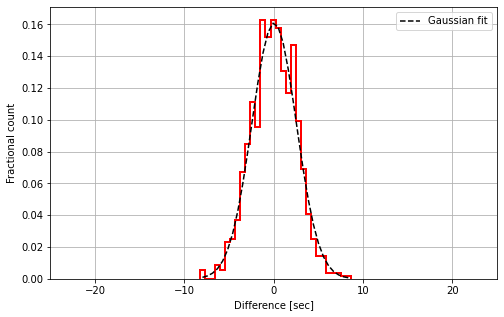

Fitted eclipse minimum time
Actual = 73.8 sec
Fitted = 75.5 +/- 2.6 sec
Difference = 1.7 sec


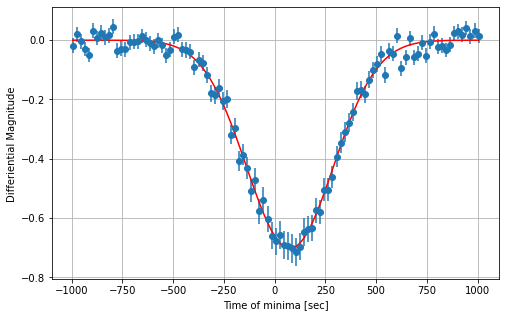

Mean Difference = -0.1 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

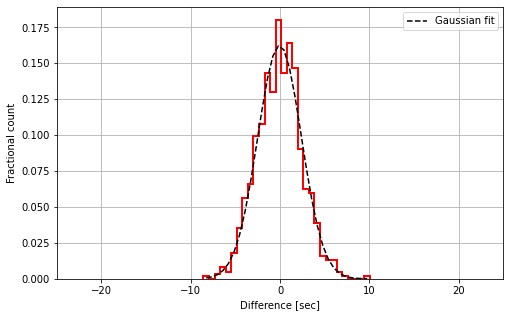

Fitted eclipse minimum time
Actual = 73.2 sec
Fitted = 74.2 +/- 2.5 sec
Difference = 1.0 sec


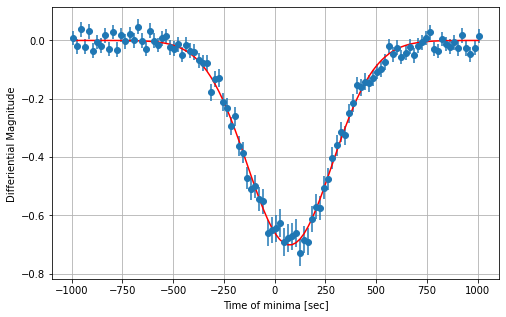

Mean Difference = 0.0 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

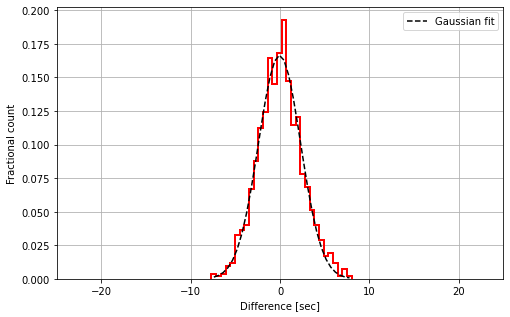

Fitted eclipse minimum time
Actual = 64.6 sec
Fitted = 66.6 +/- 2.4 sec
Difference = 2.0 sec


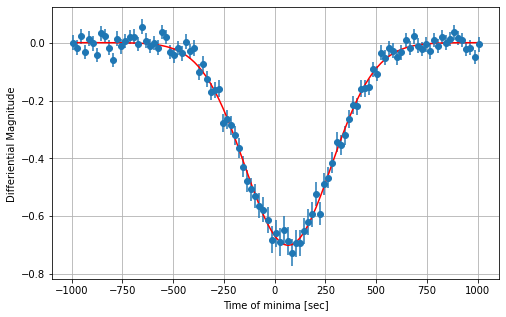

Mean Difference = 0.1 sec
Sigma = 1.8


<Figure size 432x288 with 0 Axes>

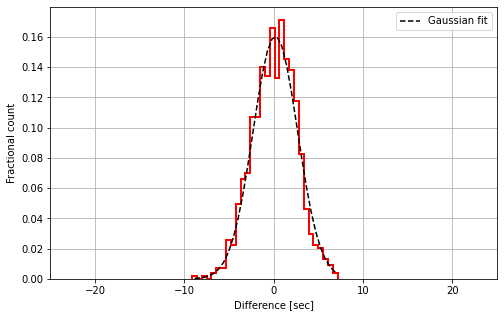

Fitted eclipse minimum time
Actual = 52.7 sec
Fitted = 50.6 +/- 2.6 sec
Difference = 2.1 sec


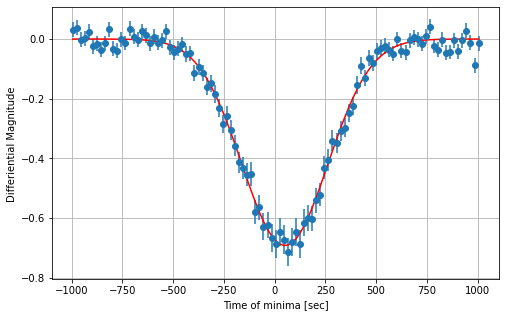

Mean Difference = -0.1 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

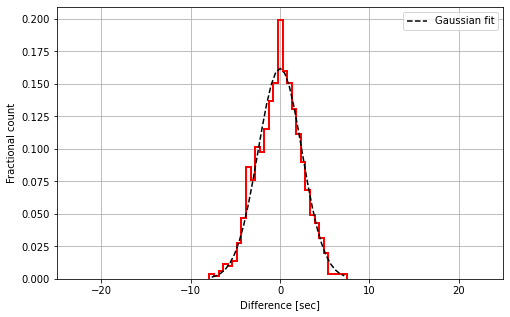

Fitted eclipse minimum time
Actual = 71.0 sec
Fitted = 75.4 +/- 2.5 sec
Difference = 4.4 sec


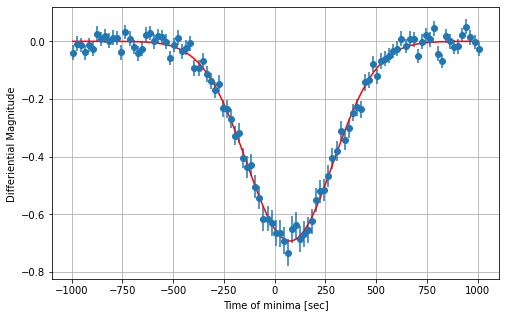

Mean Difference = -0.0 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

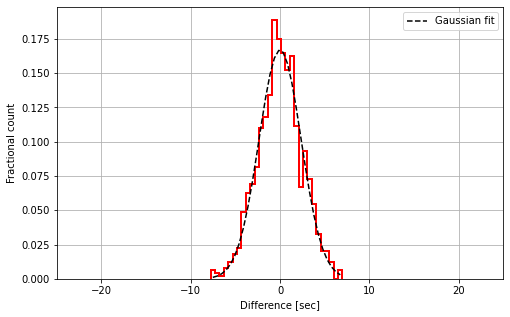

Fitted eclipse minimum time
Actual = 66.6 sec
Fitted = 64.9 +/- 2.6 sec
Difference = 1.7 sec


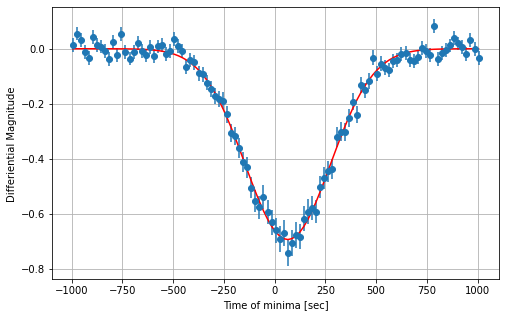

Mean Difference = 0.2 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

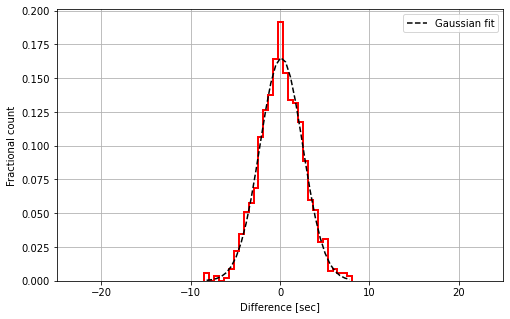

Fitted eclipse minimum time
Actual = 68.8 sec
Fitted = 69.1 +/- 2.8 sec
Difference = 0.3 sec


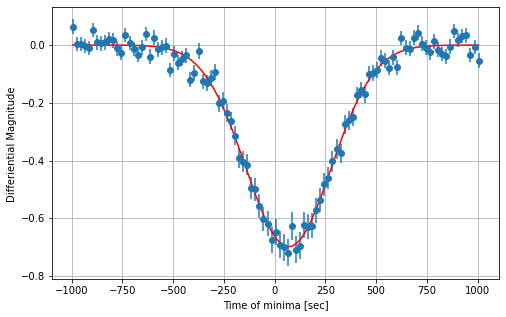

Mean Difference = -0.1 sec
Sigma = 1.7


<Figure size 432x288 with 0 Axes>

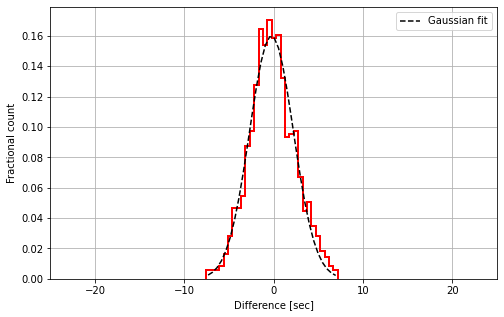

In [444]:
output2 = simulate_fit(t_exp2, N_images, Nexp)

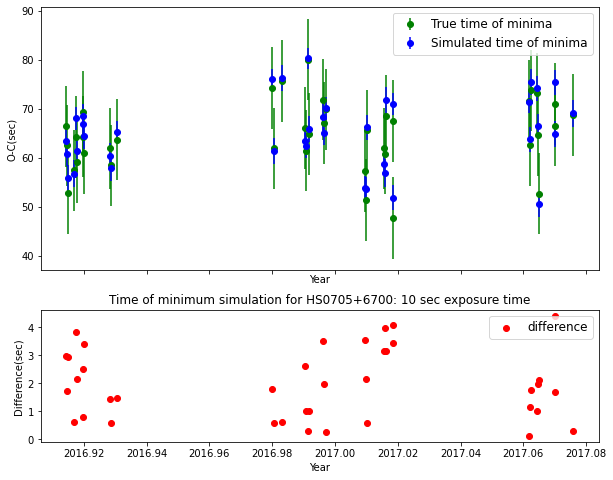

In [450]:
# Plot Models
f,(p1,p2) = plt.subplots(2,1, sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize= (10,8))
plt.title('Time of minimum simulation for HS0705+6700: 10 sec exposure time' )
p1.errorbar(yr_obs, t_off, true_sig ,fmt='o',color='g', label = 'True time of minima')
p1.errorbar(yr_obs, output2[0], output2[1] ,fmt='o',color='b', label = 'Simulated time of minima')
p1.set_xlabel('Year')
p1.set_ylabel('O-C(sec)')
p1.legend(loc='best', fontsize=12) 

p2.scatter(yr_obs, output2[2], color='r', label = 'difference')
p2.set_xlabel('Year')
p2.set_ylabel('Difference(sec)')
p2.legend(loc='best', fontsize=12) 
plt.show()

In [447]:
print(output2[3])

[1.6895779827008053, 1.7827719546565954, 1.7260373331742331, 1.7114960831631407, 1.8189596188701143, 1.7084352880309435, 1.6756264994441246, 1.694753963231175, 1.7857197844331427, 1.7957716408470628, 1.7867895411237449, 1.6857703004089257, 1.876137893382509, 1.8640293410104811, 1.8839873914030258, 1.7731832035395996, 1.836763432130271, 1.7762505226767435, 1.7045309439801708, 1.7995375333417125, 1.699179908257033, 1.8034952955045969, 1.7398932845237545, 1.7204628523304344, 1.7844911900127745, 1.6975875859387775, 1.7873636325199482, 1.7601904538847248, 1.785445157876618, 1.7419206921663204, 1.8117629393105263, 1.765752186657854, 1.7346078609491002, 1.6684915092008479, 1.767964907376357, 1.740770599942029, 1.6747454155284294, 1.6940844603755334, 1.7375605663095017]


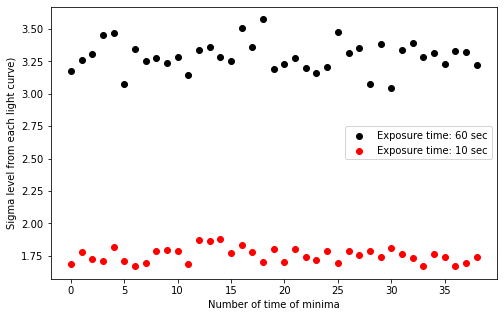

In [448]:
### compare two experiment 
# number of time of minima
Nt = np.arange(0,39)

plt.figure(figsize=(8,5))
plt.scatter(Nt, output[3], color='k', label = 'Exposure time: 60 sec')
plt.scatter(Nt, output2[3], color='r', label = 'Exposure time: 10 sec')
plt.xlabel('Number of time of minima')
plt.ylabel('Sigma level from each light curve)')
plt.legend(loc='best') 
plt.show()